# Workshop samokat_tech


The goal of this work is to determine whether there is a match between two products. We have data on products available in the market and products offered by merchants. Therefore, our task involves binary classification, where 1 indicates a match, and 0 signifies the absence of a match. Metrics should be F1 score, as set by the hosts of the workshop.

This workshop is run as a contest on the Kaggle platform, leading to several particularities:

- Handling tails poses a challenge because the test data must be processed similarly to the train data. However, in the case of dropping tails, they should be dropped in the test data as well. On Kaggle, the test data must contain the same number of rows as in a given.
- Another consideration is the size of the dataset. It may be challenging to scale the data, and models that rely on scaled data, such as SVM and neural networks, might be prohibited.

I'll start with tree-based models like CatBoost, Light GBM, and those using gradient boosting, considering the discussed factors in machine learning. I will perform hyperparameter tuning using the Optuna framework, taking into account the dataset size and other considerations.

If the outcome is unsatisfactory, I will turn to pretrained neural networks like Siamese. My observation is fitting models in batches is straightforward and won't lead to memory limit exceedances. However, scaling could be a real challenge with large datasets, especially considering I rely on open sources like Google Colab and Kaggle.

I won't use cross-validation; instead, I'll split the data into train and validation sets.

**Data description**

Columns:

1. `offer_depersonalised` and `goods_depersonalised`: Identifiers for the offer and the corresponding product, respectively.
2. `sum_length`: The total length of the pair of names and attributes in characters.
3. `attrs+title_score`: Probability of a match from the rescoring model.
4. `offer_price` and `item_price`: The price of the offer and the respective product.
5. `goods_category_id`: The category of the product.
6. `id`: Identifier for the pair `offer_depersonalised + $ + goods_depersonalised`.
7. `target` (only in train.csv): Class label (0 - no match, 1 - match).


Embeddings:

- `goods_image_vectors` and `offer_image_vectors`: Contain files with vectors of images (`embed_deperson.npy`) and their identifiers (`items_deperson.npy`) for products and offers, respectively. Objects in the files correspond 1 to 1.

- `goods_title_vectors` and `offer_title_vectors`: Contain files with vectors of titles+attributes (`embed_deperson.npy`) and their identifiers (`items_deperson.npy`) for products and offers, respectively. Objects in the files correspond 1 to 1.

Our data is represented as train and test datasets in CSV files. Embeddings are stored in NPY format. The data's size may pose challenges related to memory constraints and limits.

<div class="alert alert-block alert-success">

Молодец, что кратко описала проект и данные.

</div>

### Imports and data loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# general libraries
import pandas as pd
import numpy as np
import time
from tqdm.autonotebook import tqdm
tqdm.pandas()

# visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.size'] = 16

import gc
# ignore warnings
import warnings
warnings.filterwarnings(action='ignore',
                        category = DeprecationWarning)
# mashine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA

!pip install catboost -q
!pip install --upgrade catboost -q
import catboost
from catboost import  Pool, CatBoostClassifier

! pip install optuna -q
import optuna

# Fix the randomness parameter for the generators
SEED = 21
np.random.seed(SEED)

# Check the state of the graphics card
!nvidia-smi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.8 MB/s eta 0:00:00
Sun Feb 11 21:22:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| 

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/workshops/samokat_tech/dataset/train.csv')

In [ ]:
# load data in csv format
#train = pd.read_csv('/kaggle/input/samokat-tech/train.csv')
train.head()

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
0,295140,1396793,37,0.027267,1070,NaN,14.0,0,295140$1396793
1,65291,1396586,38,0.050415,698,NaN,14.0,0,65291$1396586
2,39232,1396244,38,0.087280,837,NaN,14.0,0,39232$1396244
3,39232,1396513,38,0.087280,837,NaN,14.0,0,39232$1396513
4,65052,1396237,38,0.079773,1085,NaN,14.0,0,65052$1396237


Data has been loaded.

## Preprocessing and analysis

Preprocessing will be carried out according to the following scenario:
- Evaluation
- Analysis of data types and, if necessary, conversion to the required data type
- Analysis of missing values and consideration of possible imputation
- Analysis of anomalous and rare values and consideration of possible replacement/deletion


<div class="alert alert-block alert-success">

Отлично, план анализа данных намечен:)

</div>

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518441 entries, 0 to 2518440
Data columns (total 9 columns):
 #   Column                Dtype  
---  ------                -----  
 0   offer_depersanalised  int64  
 1   goods_depersanalised  int64  
 2   sum_length            int64  
 3   attrs+title_score     float64
 4   offer_price           int64  
 5   goods_price           float64
 6   goods_category_id     float64
 7   target                int64  
 8   id                    object 
dtypes: float64(3), int64(5), object(1)
memory usage: 172.9+ MB


- The `offer_price` column is of type int64, while `goods_price` is float64. Confirm if this difference in data types is intentional.

- The `id` column is of object type. Depending on its content, I will encode it into a numerical format for model training.

- The memory usage is relatively high (172.9 MB).

<div class="alert alert-block alert-success">

Отлично, что обратила внимание намразличный тип у близких по смыслу столбцов.
    
Для больших датасетов оптимизация типов данных позволяет сократить объём занимаемой оперативной памяти.

Подробнее: https://towardsdatascience.com/seven-killer-memory-optimization-techniques-every-pandas-user-should-know-64707348ab20

</div>

In [ ]:
# check for unique values
print(f'''
Number of unique offers is: {train['offer_depersanalised'].nunique()}

Number of unique goods is: {train['goods_depersanalised'].nunique()}'''
)

 
Number of unique offers is: 500000

Number of unique goods is: 1592607


It's possible that a single offer corresponds to more than one item in the dataset.

In [ ]:
# Examine the unique goods grouped by offer ID
train.groupby('offer_depersanalised').agg(goods_unique = ('goods_depersanalised', 'count'),
                                         goods_category_unique = (('goods_category_id', 'nunique')))

,goods_unique,goods_category_unique
offer_depersanalised,,
0,5,2
3,5,2
4,5,4
5,5,4
8,5,1
...,...,...
572761,5,4
572762,5,2
572763,5,3


We observe that each offer can be associated with multiple goods (which is appropriate for product matching tasks). However, there is also the possibility of an offer being associated with multiple product categories, which might pose challenges and ambiguities. This consideration is noteworthy, especially given that each item on the marketplace is strictly related to a single category.

<div class="alert alert-block alert-success">

Да, верно:)

</div>

In [ ]:
# check for duplicates
train['id'].nunique()

2500000

The number of unique IDs is less than the total entries in the dataset: there are 2,500,000 unique IDs compared to 2,518,440 total entries.

These are not considered duplicates, as the same item may be used for matching with different offers. We'll specifically examine duplicates in the 'id' column since pairs of goods in our data should be unique, and it doesn't make sense to have multiple identical pairs in the dataset."

<div class="alert alert-block alert-success">

Ты совершенно верно отметила, что на самом деле это не дубликаты.

</div>

In [ ]:
# Let's check for duplicates based on the goods_depersanalised column.
train['goods_depersanalised'].duplicated().sum()

925834

In [ ]:
# let's have a look to data with duplicated
train[train['id'].duplicated(keep = False)].head(10)

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
652,357107,851154,56,0.000048,7579,34952.0,82.0,0,357107$851154
653,357107,851154,56,0.000048,7579,34952.0,81.0,0,357107$851154
4850,19880,790671,67,0.000038,4658,2960.0,83.0,0,19880$790671
4851,19880,790671,67,0.000038,4658,2960.0,82.0,0,19880$790671
5337,21236,790671,67,0.076294,3037,2960.0,83.0,0,21236$790671
5338,21236,790671,67,0.076294,3037,2960.0,82.0,0,21236$790671
10889,314195,790669,74,0.000041,1607,1833.0,83.0,0,314195$790669
10890,314195,790669,74,0.000041,1607,1833.0,82.0,0,314195$790669
12158,314243,790669,75,0.000116,1127,1833.0,83.0,0,314243$790669
12159,314243,790669,75,0.000116,1127,1833.0,82.0,0,314243$790669


In [ ]:
# drop duplicated data
train.drop_duplicates(subset ='id',
                      keep = 'first',
                      inplace = True,
                      ignore_index = False)

I notice that they differ in the 'goods_category_id' feature, which should be unique for each item. To eliminate ambiguity in matching, I'll remove these entries.

<div class="alert alert-block alert-success">

Ок:)

</div>

In [ ]:
# check
train['id'].duplicated(keep = False).sum()

0

In [ ]:
#  Examine the unique categories grouped by goods
# to ensure they are unique for each item in the market
goods_categories = train.groupby('goods_depersanalised')\
                            .agg(categories_unique = ('goods_category_id', 'nunique'))

goods_categories.loc[goods_categories['categories_unique'] >1]

,categories_unique
goods_depersanalised,


### Missing values

In [ ]:
train.isna().sum()

offer_depersanalised         0
goods_depersanalised         0
sum_length                   0
attrs+title_score            0
offer_price                  0
goods_price             404807
goods_category_id          833
target                       0
id                           0
dtype: int64

<div class="alert alert-block alert-warning">

Отлично, число пропусков по столбцам вычислено, но более показательным является процент пропусков по столбцам, т. к. позволяет оценить какие подходы к обработке пропусков можно применить (т. к. понятно какой процент от исходных данных составляют пропуски).

Рассчитать число пропусков можно как:

df.isnull().sum() / len(df)

</div>

In [ ]:
# initialize a function to visualize missing values
def pass_value_barh(df):
    try:(
        (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh',
                  figsize = (19,6),
                  rot = -0,
                  legend = False,
                  fontsize = 16,
                  xticks=[i/10 for i in range(0, 1000, 50)],
                  color='skyblue')
            .set_title('Number of missing values' + "\n", fontsize = 22, color = 'Black')
        );
    except:
        print('No missing values')

<div class="alert alert-block alert-warning">

Советую при написании кода придерживаться правил PEP8 и добавить документацию (docstrings) к функциям.

Подробнее:

https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html
https://peps.python.org/pep-0257/

</div>

<div class="alert alert-block alert-warning">

При обработке исключений лучше обрабатывать конкретный тип исключения.
Подробнее:
1. https://habr.com/ru/companies/wunderfund/articles/736526/
2. https://academy.yandex.ru/handbook/python/article/model-isklyuchenij-python-try-except-else-finally-moduli
    
</div>

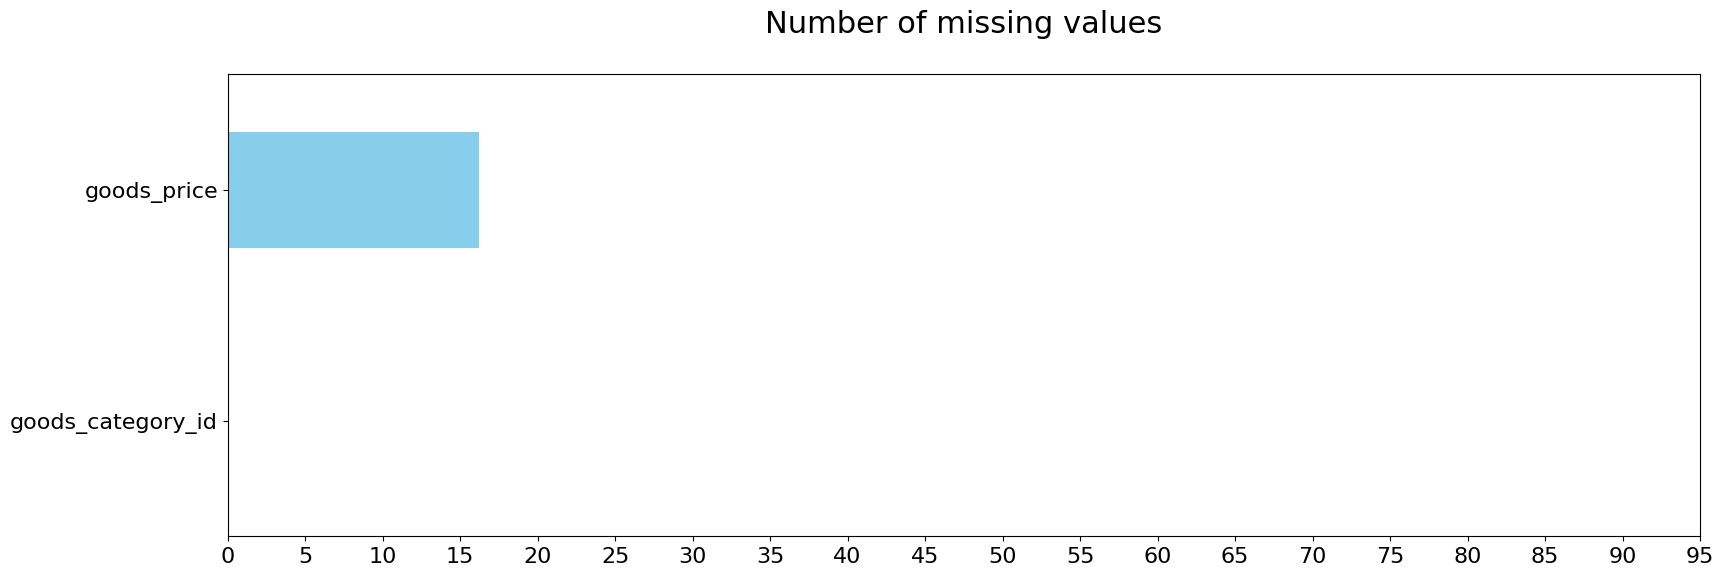

In [ ]:
pass_value_barh(train)

We cannot simply drop all missing values altogether. Upon inspection, we notice a minimal amount of missing values in one category (goods_category_id 892), while the 'price' column has 407,287 missing values. Primarily, missing values are prevalent in the 'goods_price' column. To address this, we can fill missing values in the 'goods_price' column with the average price of the respective goods category and drop missing values in the 'goods_category_id' column.

<div class="alert alert-block alert-warning">

В случае если распределение признака отлично от нормального, то нужно заменять пропуски не на среднее значение, а на медиану, т. к. она более устойчива к выбросам.

</div>

In [ ]:
# look at the data where there are missing values
train.loc[train['goods_price'].isna() | train['goods_category_id'].isna()].head(10)

,offer_depersanalised,goods_depersanalised,sum_length,attrs+title_score,offer_price,goods_price,goods_category_id,target,id
0,295140,1396793,37,0.027267,1070,NaN,14.0,0,295140$1396793
1,65291,1396586,38,0.050415,698,NaN,14.0,0,65291$1396586
2,39232,1396244,38,0.087280,837,NaN,14.0,0,39232$1396244
3,39232,1396513,38,0.087280,837,NaN,14.0,0,39232$1396513
4,65052,1396237,38,0.079773,1085,NaN,14.0,0,65052$1396237
5,90396,1396237,38,0.079773,350,NaN,14.0,0,90396$1396237
6,373848,1396822,39,0.000035,1391,NaN,14.0,0,373848$1396822
7,295140,1396237,39,0.065979,1070,NaN,14.0,0,295140$1396237
9,64799,1396335,40,0.047699,348,NaN,14.0,0,64799$1396335
10,379158,1396822,40,0.020340,856,NaN,14.0,0,379158$1396822


In [ ]:
# attempt to identify missing cats by grouping the data on goods
train.groupby('goods_depersanalised')\
                                        .agg(categories = ('goods_category_id', 'unique'),
                                             num_categories = ('goods_category_id', 'nunique'))\
                                        .sort_values(by = 'num_categories', ascending = False)

,categories,num_categories
goods_depersanalised,,
1760567,[81.0],1
0,[82.0],1
1,[82.0],1
2,[82.0],1
3,[82.0],1
...,...,...
1637007,[nan],0
1635997,[nan],0
1634300,[nan],0


Since all objects in 'goods_depersonalised' refer to a single category, making it challenging to identify the associated category for each good, I need to fill those values with a placeholder. This placeholder should differ from other categories, providing the model with information about missing values in this context.

In [ ]:
# find a placeholder to fill with
train['goods_category_id'].unique()

array([1.40000000e+01, 2.00000000e+00, 8.10000000e+01, 8.00000000e+00,
       1.90000000e+01, 3.00000000e+00, 1.10000000e+01, 2.10000000e+01,
       5.00000000e+00, 6.00000000e+00, 8.30000000e+01, 8.20000000e+01,
       4.00000000e+00, 7.00000000e+00, 2.46368463e+15, 1.30000000e+01,
                  nan, 1.70000000e+01, 9.00000000e+00, 6.90000000e+01,
       1.80000000e+01])

All categories appear to be in scientific notation, likely due to category '2463684633817211'. Let's correct this issue by replacing it with 10

In [ ]:
# replace cat which inconvinient with value 10
train.loc[train['goods_category_id'] == 2463684633817211.0, 'goods_category_id'] = 10

In [ ]:
train['goods_category_id'].unique()

array([14.,  2., 81.,  8., 19.,  3., 11., 21.,  5.,  6., 83., 82.,  4.,
        7., 10., 13., nan, 17.,  9., 69., 18.])

In [ ]:
# Fill missing values with negative placeholder to make them easily distinguishable from original categories.
train['goods_category_id'] = train['goods_category_id'].fillna(-5)
# check
train['goods_category_id'].isna().sum()

0

Now we have to find a value to fit all missing values in goods_price column. Filling with the mean or median val of price seems to be a good idea, if the range of that values is not so wide

<div class="alert alert-block alert-success">

Да, логично:)

</div>

In [ ]:
# estimate the mean and median value of the price grouped by category
price_grouped = train.groupby(['goods_category_id']).agg(mean_price = ('goods_price', 'mean'),
                                         median_price = ('goods_price', 'median'))
price_grouped

,mean_price,median_price
goods_category_id,,
-5.0,12626.189824,1970.0
2.0,12195.233419,3490.0
3.0,1874.055396,784.0
4.0,175420.687040,1395.0
5.0,10749.470963,1965.0
6.0,279496.682315,2449.0
7.0,912.359626,521.0
8.0,27467.064628,13830.5
9.0,2387.563446,932.0


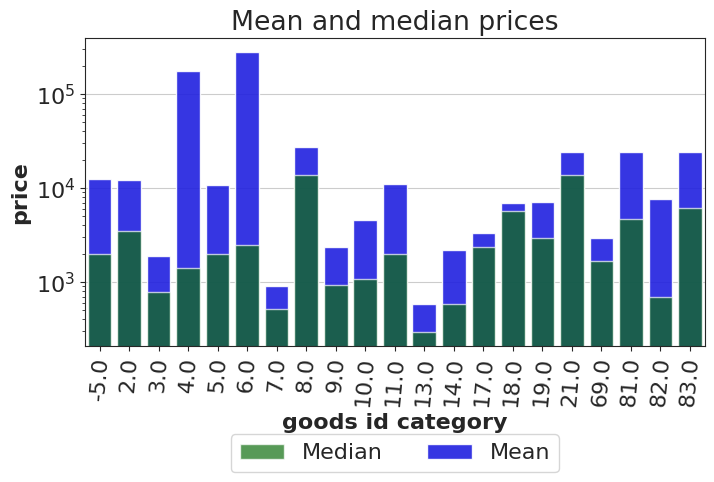

In [ ]:
plt.figure(figsize=(8, 4))
sns.set_style('ticks', {'axes.grid': True})
# Create a bar chart for mean values
mean_plot = sns.barplot(x = price_grouped.index,
                            y = price_grouped['mean_price'],
                            color = 'blue',
                            alpha = 0.9,
                            label = 'Mean')

# Create a bar chart for median values
median_plot = sns.barplot(x = price_grouped.index,
                            y = price_grouped['median_price'],
                            color = 'green',
                            alpha = 0.7,
                            label = 'Median')
# set labels
plt.xlabel('goods id category', fontweight='bold')

plt.ylabel('price', fontweight='bold')

plt.title(f'Mean and median prices')

plt.xticks(rotation = 85)

plt.yscale('log') # make values of different scales visible

# customizing a legend
handles, labels = plt.gca().get_legend_handles_labels()

handles.reverse()
labels.reverse()
plt.legend(handles,
            labels,
            bbox_to_anchor=(0.5, -0.25),
               loc='upper center',
               ncol=2)

plt.show()

<div class="alert alert-block alert-danger">

Анализ графиков и формулировка выводов это важная часть работs, поэтому нужно описать какой вывод следует из построенного графика.

</div>

In [ ]:
# Assess the distribution of values so that after filling, we can evaluate the change in the distribution
train[['goods_price']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
goods_price,2095193.0,48285.903967,7.969484e+06,101.0,664.0,1772.0,6498.0,2.106021e+09


Since filling with the mean price may skew our data due to long tails, it is preferable to use the median value of the price for filling

In [ ]:
# creating a mapping of the median price value for each  goods_category_id
median_price_map = train.groupby(['goods_category_id'])['goods_price'].median()
median_price_map

goods_category_id
-5.0      1970.0
 2.0      3490.0
 3.0       784.0
 4.0      1395.0
 5.0      1965.0
 6.0      2449.0
 7.0       521.0
 8.0     13830.5
 9.0       932.0
 10.0     1090.0
 11.0     2009.0
 13.0      294.0
 14.0      578.0
 17.0     2332.0
 18.0     5697.5
 19.0     2930.0
 21.0    13870.0
 69.0     1690.0
 81.0     4291.0
 82.0      688.0
 83.0     5931.0
Name: goods_price, dtype: float64

In [ ]:
# take a look at the original entries in the database
train.loc[train['goods_price'].isna(),['goods_price', 'goods_category_id']].sample(10)

,goods_price,goods_category_id
290134,NaN,6.0
432740,NaN,5.0
713439,NaN,5.0
18089,NaN,11.0
1114261,NaN,14.0
33551,NaN,2.0
324390,NaN,83.0
527355,NaN,5.0
237519,NaN,2.0
528741,NaN,5.0


In [ ]:
# mapping the missing goods_price values based on their corresponding goods_category_id
# to the previously calculated median values replace entries with NaNs with the median value
train.loc[train['goods_price'].isna(), 'goods_price'] = train.loc[train['goods_price'].isna(), 'goods_category_id'] \
                                                    .map(median_price_map)

In [ ]:
# check
train['goods_price'].isna().sum()

0

In [ ]:
# assess the distribution of values after filling,
train[['goods_price']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
goods_price,2500000.0,40921.156119,7.295807e+06,101.0,705.0,1965.0,5400.0,2.106021e+09


In [ ]:
# change the data types of both features to float
train[['offer_price', 'goods_price']] = train[['offer_price', 'goods_price']].astype('int')
train[['offer_price', 'goods_price']] .dtypes

offer_price    int64
goods_price    int64
dtype: object

The characteristics of the distribution have not changed, indicating that the process of filling was conducted correctly

<div class="alert alert-block alert-success">

 👍👍👍

</div>

## Outliers and rare values

Since we can't drop anomalous values in the test data, I will examine it first. Only after examining the test data for such values will I decide what action to take, if needed.

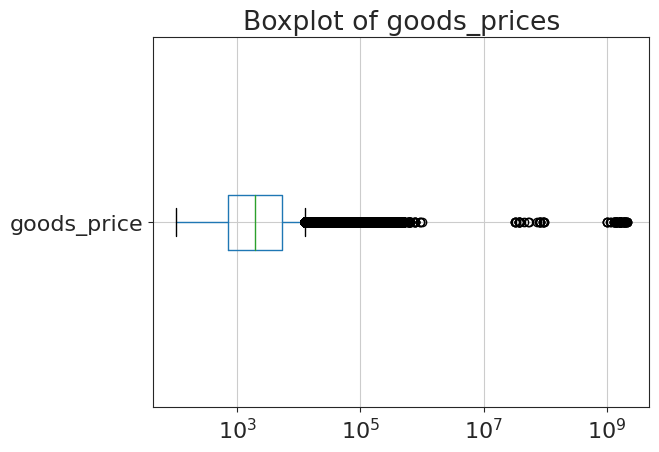

In [ ]:
train[['goods_price']].boxplot(vert = False)
plt.title('Boxplot of goods_prices')
plt.xscale('log')

In [ ]:
# look at quantiles of values
train[['goods_price']].quantile([.005, .98, .99, .9998])

,goods_price
0.0050,145.00
0.9800,72084.02
0.9900,108000.00
0.9998,449100.00


Objects priced in billions seem unrealistic for a marketplace, and moreover, they are very rare. It would be better to remove them if these outliers are not present in the test dataset.

<div class="alert alert-block alert-warning">

Дополнительно можно вычислить границы выбросов по методу IQR.

Материалы по “ящикам с усами”: https://builtin.com/data-science/boxplot

</div>

### Conclusion on Data Preprocessing


After the initial data preprocessing, the following aspects were investigated:

1. No encoding is required for data types, as all features are numerical.
2. Outliers and rare values were assessed.

3. Missing values in feature 2 were imputed with the median value for the corresponding goods category. After imputation, the characteristics of the data distribution remained unchanged.

4. Data types in the features "goods_price" and "offer_price" were converted to the same integer type.

<div class="alert alert-block alert-success">

Отлично, итог анализа подведён 👍👍👍

Дополнительные материалы по “ящикам с усами”: https://builtin.com/data-science/boxplot

</div>

## Embeddings

We have been provided with embeddings for textual descriptions and images of products. The method used to obtain these embeddings is unknown.

- `goods_image_vectors`
  - `embed_deperson.npy`: Vectors for images.
  - `items_deperson.npy`: Vectors identified by product identifiers for the assortment of goods.

- `offer_image_vectors`
  - `embed_deperson.npy`: Vectors for images.
  - `items_deperson.npy`: Vectors identified by product identifiers for the offered goods.

## Goods embeddings

### Goods image

In [ ]:
# embeddings for goods on market
#goods_image_path = '/kaggle/input/samokat-tech/goods_image_vectors/goods_image_vectors/embed_deperson.npy'
goods_image_path = '/content/drive/MyDrive/workshops/samokat_tech/dataset/goods_image_vectors/goods_image_vectors/embed_deperson.npy'
# their id
#goods_id_path = '/kaggle/input/samokat-tech/goods_image_vectors/goods_image_vectors/items_deperson.npy'
goods_id_path = '/content/drive/MyDrive/workshops/samokat_tech/dataset/goods_image_vectors/goods_image_vectors/items_deperson.npy'

In [ ]:
# load  and open the embeddings
goods_image_vector = np.load(goods_image_path)
goods_id_vector = np.load(goods_id_path)

print(f'''
Image vector size: {goods_image_vector.shape}

Identifier vector size: {goods_id_vector.shape}''')


Image vector size: (317707, 256)

Identifier vector size: (317707,)


The sizes match

In [ ]:
# NumPy array with embeddings
embedding_matrix = goods_image_vector

# Specify the percentage of explained variance we want to retain
explained_variance_percentage = 99

# Create a PCA object and reduce dimensionality
pca = PCA(n_components=explained_variance_percentage / 100, svd_solver='full')
reduced_good_img = pca.fit_transform(goods_image_vector)

print("Original dimensionality:", embedding_matrix.shape[1])
print()
print("Reduced dimensionality:", reduced_good_img.shape[1])
print()
print("Explained variance:", np.sum(pca.explained_variance_ratio_))

Original dimensionality: 256

Reduced dimensionality: 244

Explained variance: 0.9906756597487889


In [ ]:
# asses values in the goods_id_vector
goods_id_vector[:35]

array(['37', '39', '49', '52', '67', '76', '81', '88', '98', '104', '108',
       '117', '118', '120', '124', '127', '131', '132', '133', '134',
       '135', '136', '138', '139', '141', '146', '147', '149', '150',
       '153', '158', '159', '162', '182', '185'], dtype='<U7')

In [ ]:
# make int from str
goods_id_vector_int = list(map(int, goods_id_vector))

In [ ]:
goods_image_vector.shape[1]

256

To make it more convenient to work with the data, let's generate feature names for each embedding

In [ ]:
# generate columns names
goods_image_names = []
for col in range(reduced_good_img.shape[1]):
    goods_image_names.append('goods_img_' + str(col))

In [ ]:
# create a df og image embeddings
goods_img = pd.DataFrame(reduced_good_img, columns = goods_image_names)
goods_img['goods_depersanalised'] = goods_id_vector_int
goods_img.head()

,goods_img_0,goods_img_1,goods_img_2,goods_img_3,goods_img_4,goods_img_5,goods_img_6,goods_img_7,goods_img_8,goods_img_9,...,goods_img_235,goods_img_236,goods_img_237,goods_img_238,goods_img_239,goods_img_240,goods_img_241,goods_img_242,goods_img_243,goods_depersanalised
0,-4.113428,1.059448,-0.388284,-1.274160,0.525343,-1.895455,-1.161472,1.424942,-5.495380,1.413485,...,-0.389224,1.569693,-0.465296,0.530030,-0.397986,-1.334778,0.111554,-0.137931,-0.385070,37
1,-3.115640,1.041265,0.643746,-1.497771,1.339977,-1.654738,-0.989378,1.381975,-5.723094,1.487579,...,-0.436009,1.825325,-0.061663,0.837640,-0.097251,-1.388590,-0.267868,0.009400,-0.172846,39
2,7.014368,-2.883742,-2.395493,-1.268309,-5.181050,-1.663070,1.647138,-2.054772,-3.271804,4.274426,...,-0.542351,0.209680,-0.132317,-0.176484,-0.743614,0.678559,0.292385,-0.852012,-0.183054,49
3,2.195787,-6.162120,-0.687444,1.875920,0.039037,3.356045,-1.084920,0.999182,-2.420221,-3.565885,...,-0.953054,-0.377496,-0.230234,1.022310,0.984890,-1.201735,-0.703851,-0.233174,0.558588,52
4,2.619878,-2.738864,-3.515036,-2.299964,-0.609245,1.281840,-2.630155,-0.827734,-2.548260,-1.779194,...,0.072044,0.737261,0.177854,-0.708998,0.769565,-0.330839,-1.792050,-0.833672,-0.107700,67


In [ ]:
# access the presence of the image embedings id in data
train[train['goods_depersanalised'].isin(goods_id_vector_int)]['goods_depersanalised'].nunique()

288019

In [ ]:
train.shape

(2500000, 9)

There is no embedding for each entry in the image data, which may be due to the specificity of the object. We should look at another embedding.

### Goods title

- `goods_title_vectors` for assortment goods
  - `embed_deperson.npy`: Vectors of titles + attributes.
  - `items_deperson.npy`: Identifiers.

- `offer_title_vectors` for offered goods
  - `embed_deperson.npy`: Vectors of titles + attributes.
  - `items_deperson.npy`: Identifiers.

In [ ]:
# embeddings for goods title on market
#goods_title_path = '/kaggle/input/samokat-tech/goods_title_vectors/goods_title_vectors/embed_deperson.npy'

goods_title_path = '/content/drive/MyDrive/workshops/samokat_tech/dataset/goods_title_vectors/goods_title_vectors/embed_deperson.npy'

# their id
#goods_id_title_path = '/kaggle/input/samokat-tech/goods_title_vectors/goods_title_vectors/items_deperson.npy'
goods_id_title_path = '/content/drive/MyDrive/workshops/samokat_tech/dataset/goods_title_vectors/goods_title_vectors/items_deperson.npy'

In [ ]:
# load  and open the embeddings
goods_title_vector = np.load(goods_title_path)
goods_id_title_vector = np.load(goods_id_title_path)

print(f'''
Size of embeddings with attributes: {goods_title_vector.shape}

Size of embeddings with id for attributes: {goods_id_title_vector.shape}''')


Size of embeddings with attributes: (1760568, 64)

Size of embeddings with id for attributes: (1760568,)


In [ ]:
goods_id_title_vector[:15]

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14'], dtype='<U7')

In [ ]:
# change type
goods_id_title_int = list(map(int, goods_id_title_vector))

In [ ]:
# access the presence of the title embedings id in data
train[train['goods_depersanalised'].isin(goods_id_title_int)]['goods_depersanalised'].nunique()

1592607

All entries in data have its own embedding

In [ ]:
# NumPy array with embeddings
embedding_matrix = goods_title_vector

# percentage of explained variance wewant to retain
explained_variance_percentage = 99
# reducing dimensionality
pca = PCA(n_components=explained_variance_percentage / 100, svd_solver='full')
reduced_goods_title = pca.fit_transform(goods_title_vector)

# Print the results
print("Original dimensionality:", embedding_matrix.shape[1])
print()
print("Reduced dimensionality:", reduced_goods_title.shape[1])
print()
print("Explained variance:", np.sum(pca.explained_variance_ratio_))

Original dimensionality: 64

Reduced dimensionality: 64

Explained variance: 1.0


In [ ]:
# generate columns names
goods_title_names = []
for col in range(reduced_goods_title.shape[1]):
    goods_title_names.append('goods_tit_' + str(col))

In [ ]:
# have a look at resulting df with goods titles
goods_title = pd.DataFrame(reduced_goods_title, columns = goods_title_names )
goods_title['goods_depersanalised'] = goods_id_title_int
goods_title.head()

,goods_tit_0,goods_tit_1,goods_tit_2,goods_tit_3,goods_tit_4,goods_tit_5,goods_tit_6,goods_tit_7,goods_tit_8,goods_tit_9,...,goods_tit_55,goods_tit_56,goods_tit_57,goods_tit_58,goods_tit_59,goods_tit_60,goods_tit_61,goods_tit_62,goods_tit_63,goods_depersanalised
0,0.005008,-0.011613,-0.070027,0.004129,-0.019151,0.111157,0.029526,0.006800,-0.115877,-0.137511,...,-0.091552,-0.041554,-0.030708,0.128406,0.036607,-0.033614,0.042705,0.009731,0.075476,0
1,0.021852,-0.037774,-0.005905,0.050912,-0.012081,0.018669,0.034319,0.009007,0.006013,-0.144275,...,0.000384,-0.020024,-0.027436,-0.132383,0.102485,0.059278,0.011910,-0.043056,-0.059932,1
2,-0.092182,-0.132652,0.056126,0.002748,0.121413,-0.058015,0.054919,-0.030908,-0.023413,-0.144530,...,0.039683,0.038745,-0.027012,0.067007,0.032767,-0.014709,0.053841,0.054044,0.137854,2
3,0.071760,-0.088988,-0.045938,-0.058460,-0.075341,-0.174374,-0.064244,-0.094638,0.150600,0.120026,...,-0.134975,0.161361,0.025702,0.019557,0.045703,-0.029478,-0.130734,0.217725,0.143074,3
4,0.002701,-0.014992,-0.093796,-0.062873,-0.063951,-0.078271,-0.119662,-0.206677,0.107165,0.048252,...,-0.053887,-0.047705,0.005454,0.142638,0.013304,-0.040493,0.044802,0.016654,0.090728,4


<div class="alert alert-block alert-success">

Отлично, ээмбеддинги проанализированы 👍👍👍
    
Дополнительно можно посмотреть: https://habr.com/ru/companies/wunderfund/articles/590651/
    
</div>

## Offers embedding

### Offers image

In [ ]:
# embeddings for goods on market
#offer_image_path = '/kaggle/input/samokat-tech/offer_image_vectors/offer_image_vectors/embed_deperson.npy'
offer_image_path =  '/content/drive/MyDrive/workshops/samokat_tech/dataset/offer_image_vectors/offer_image_vectors/embed_deperson.npy'

# their id
#offer_id_image_path = '/kaggle/input/samokat-tech/offer_image_vectors/offer_image_vectors/items_deperson.npy'
offer_id_image_path = '/content/drive/MyDrive/workshops/samokat_tech/dataset/offer_image_vectors/offer_image_vectors/items_deperson.npy'

In [ ]:
# load  and open the embeddings
offer_image_vector = np.load(offer_image_path)
offer_id_image_vector = np.load(offer_id_image_path)

print(f'''
Size of embeddings with images of offers: {offer_image_vector .shape}

Size of embeddings with id for images of offers: {offer_id_image_vector.shape}''')


Size of embeddings with images of offers: (457586, 256)

Size of embeddings with id for images of offers: (457586,)


In [ ]:
# change type
offers_id_image_int = list(map(int, offer_id_image_vector))

In [ ]:
train['offer_depersanalised'].nunique()

500000

In [ ]:
# asess the presence of the title embedings id in the data
train[train['offer_depersanalised'].isin(offers_id_image_int)]['offer_depersanalised'].nunique()

399334

In [ ]:
# NumPy array with embeddings
embedding_matrix = offer_image_vector

# percentage of explained variance we want to retain
explained_variance_percentage = 99

#  reduce dimensionality
pca = PCA(n_components = explained_variance_percentage / 100, svd_solver = 'full')
reduced_offer_image_vector = pca.fit_transform(offer_image_vector)

# Print the results
print("Original dimensionality:", embedding_matrix.shape[1])
print()
print("Reduced dimensionality:", reduced_offer_image_vector.shape[1])
print()
print("Explained variance:", np.sum(pca.explained_variance_ratio_))


Original dimensionality: 256

Reduced dimensionality: 244

Explained variance: 0.9905097771333333


In [ ]:
# generate columns names
offers_image_names = []
for col in range(reduced_offer_image_vector.shape[1]):
    offers_image_names.append('offers_img_' + str(col))

In [ ]:
offers_img = pd.DataFrame(data = reduced_offer_image_vector,
                          columns = offers_image_names)

offers_img['offer_depersanalised'] = offers_id_image_int
offers_img.head()

,offers_img_0,offers_img_1,offers_img_2,offers_img_3,offers_img_4,offers_img_5,offers_img_6,offers_img_7,offers_img_8,offers_img_9,...,offers_img_235,offers_img_236,offers_img_237,offers_img_238,offers_img_239,offers_img_240,offers_img_241,offers_img_242,offers_img_243,offer_depersanalised
0,-1.165890,4.951701,-2.943292,-0.987861,0.427830,-7.009815,0.100047,-1.721531,-2.904701,1.615312,...,-0.152506,0.877293,-1.308812,0.693474,-2.475516,-0.127380,0.568722,0.432275,1.394381,140
1,-3.939162,2.777814,-1.029983,-5.225879,-3.327327,1.735294,-2.214345,1.511335,0.732150,-1.158267,...,-0.928104,-0.339694,0.571039,0.094195,-0.099206,0.131785,-0.377144,2.180938,0.559537,185
2,-3.955693,-1.945738,1.358220,-2.456299,-2.272316,1.429618,1.109723,1.083648,3.068481,-4.273599,...,-0.676123,-0.254565,0.797011,0.710344,0.342061,0.176960,0.616458,-0.335788,0.369211,187
3,-2.831478,3.916972,-2.764339,-1.768405,-0.707942,-5.212907,-0.977440,-0.528074,-2.595964,2.185070,...,-0.181382,0.078583,0.409449,-1.758711,1.126899,0.246738,0.499159,1.378545,-0.278640,206
4,1.370496,2.702963,-1.201790,4.730123,-1.106487,0.847876,2.957433,0.192080,-3.572902,3.076519,...,0.444943,-0.149525,-0.078857,-0.485624,-0.548977,-0.043612,-0.135041,0.970713,0.569644,242


### Offers title

In [ ]:
# embeddings for goods on market
#offer_title_path = '/kaggle/input/samokat-tech/offer_title_vectors/offer_title_vectors/embed_deperson.npy'
offer_title_path = '/content/drive/MyDrive/workshops/samokat_tech/dataset/offer_title_vectors/offer_title_vectors/embed_deperson.npy'

# their id
#offer_id_title_path = '/kaggle/input/samokat-tech/offer_title_vectors/offer_title_vectors/items_deperson.npy'
offer_id_title_path = '/content/drive/MyDrive/workshops/samokat_tech/dataset/offer_title_vectors/offer_title_vectors/items_deperson.npy'

In [ ]:
# load  and open the embeddings
offer_title_vector = np.load(offer_title_path)
offer_id_title_vector = np.load(offer_id_title_path)

print(f'''
Size of embeddings with attributes of offers: {offer_title_vector.shape}

Size of embeddings with id for attributes of offers: {offer_id_title_vector.shape}''')


Size of embeddings with attributes of offers: (572767, 64)

Size of embeddings with id for attributes of offers: (572767,)


In [ ]:
# change type
offer_id_title_int = list(map(int, offer_id_title_vector))

In [ ]:
#  array of embeddings
embedding_matrix = offer_title_vector

#  the percentage of explained variance
explained_variance_percentage = 99

#  reduce dimensionality
pca = PCA(n_components = explained_variance_percentage / 100, svd_solver = 'full')
reduced_offer_title_vector = pca.fit_transform(offer_title_vector)

# Print the results
print("Original dimensionality:", embedding_matrix.shape[1])
print()
print("Reduced dimensionality:", reduced_offer_title_vector.shape[1])
print()
print("Explained variance:", np.sum(pca.explained_variance_ratio_))


Original dimensionality: 64

Reduced dimensionality: 64

Explained variance: 0.9999999999999999


In [ ]:
# generate columns names
offers_title_names = []
for col in range(reduced_offer_title_vector.shape[1]):
    offers_title_names.append('offers_tit_' + str(col))

In [ ]:
# df with titles of offers
offer_title = pd.DataFrame(data = reduced_offer_title_vector,
                           columns = offers_title_names)
offer_title['offer_depersanalised'] = offer_id_title_int
offer_title.head()

,offers_tit_0,offers_tit_1,offers_tit_2,offers_tit_3,offers_tit_4,offers_tit_5,offers_tit_6,offers_tit_7,offers_tit_8,offers_tit_9,...,offers_tit_55,offers_tit_56,offers_tit_57,offers_tit_58,offers_tit_59,offers_tit_60,offers_tit_61,offers_tit_62,offers_tit_63,offer_depersanalised
0,-0.098860,0.051223,0.030604,0.066654,-0.010252,-0.056368,-0.017117,0.085561,0.015588,-0.069684,...,-0.110670,-0.040790,-0.123178,-0.050740,0.038711,-0.130046,-0.016284,-0.084010,-0.026399,477447
1,0.120491,-0.043145,0.070033,-0.058011,0.053814,0.048648,-0.025574,0.035184,0.071211,0.099382,...,-0.073179,0.003015,0.022021,-0.035409,0.007700,-0.015132,-0.009057,0.041761,0.066948,95232
2,-0.050368,-0.029068,0.025234,-0.023668,-0.174921,0.031126,-0.139199,-0.064207,-0.051486,0.143433,...,-0.109044,-0.066028,0.073605,0.032031,-0.086157,-0.002718,-0.008626,-0.031869,-0.032344,117886
3,0.024398,-0.122338,0.041359,-0.064691,0.077898,-0.046255,-0.056614,-0.076559,-0.133840,0.079991,...,0.008914,0.008784,-0.048365,0.044204,-0.048655,0.036327,-0.059634,0.052520,-0.067693,218467
4,-0.117548,-0.033242,0.040344,-0.039431,-0.099744,-0.052083,0.039100,0.041178,0.044233,0.024030,...,-0.012621,-0.025665,-0.117493,0.000830,0.099397,-0.061479,0.068587,-0.044882,-0.156244,399432


**Create a new feature based on distances between vectors.
For this, I will create two vectors (image vectors for goods and corresponding vectors for offers).
Then, I will create a vector of distances with a length corresponding to the number of objects in the vectors.
This procedure is resource-intensive, so I saved the resulting vectors and loaded them later on the platform.
The code is available in markdown.**

<div class="alert alert-block alert-success">

Да, генерация новых признаков это отличная идея:)

</div>



```
a = train_with_img[offers_image_names].fillna(0.0)

b = train_with_img[goods_image_names].fillna(0.0)

result = np.zeros([1, 1])

for i in tqdm(list(a.index)):
    dist = pairwise_distances(np.array(a.iloc[i]).reshape(1, -1),
    array(b.iloc[i]).reshape(1, -1),
    metric = 'sqeuclidean')
    
    result = np.concatenate((result, dist))
    
        if i % 1000000 == 0:
    print(result.shape)
np.save('train_dist', result)
```



```
a = train_with_title[offers_title_names].fillna(0.0)
b = train_with_title[goods_title_names].fillna(0.0)
print(f'''{a.shape}, {b.shape}''')

result = np.zeros([1, 1])
for i in tqdm(list(a.index)):
    dist = pairwise_distances(np.array(a.iloc[i]).reshape(1, -1),
                              np.array(b.iloc[i]).reshape(1, -1),
                              metric = 'sqeuclidean')
    result = np.concatenate((result, dist))
    
    if i % 1000000 == 0:
        print(result.shape)
        
np.save('train_title_dist', result)
```

In [ ]:
gc.collect()

7510

In [ ]:
# add distanses between title's vectors to a dataframe
train['title_dist'] = np.load('/kaggle/input/train-title/train_title_dist.npy')[1:]
# vector distance between images
train['img_dist'] = np.load('/kaggle/input/train-distances/train_dist.npy')[1:]

In [ ]:
# access the presence of the title embedings id in data
train[train['offer_depersanalised'].isin(offer_id_title_int)]['offer_depersanalised'].nunique()

500000

## Adding embeddings to main DF

In [ ]:
# add embeddings to the data
train_with_title = pd.merge(train, goods_title.drop_duplicates('goods_depersanalised'),
                        on = 'goods_depersanalised',
                        how = 'left')

train_with_title = pd.merge(train_with_title, offer_title.drop_duplicates('offer_depersanalised'),
                        on = 'offer_depersanalised',
                        how = 'left')

train_with_title.shape

(2518441, 137)

In [ ]:
# add embeddings to the data
train_all = pd.merge(train_with_title, goods_img.drop_duplicates('goods_depersanalised'),
                          on = 'goods_depersanalised',
                          how = 'left')

train_all = pd.merge(train_all, offers_img.drop_duplicates('offer_depersanalised'),
                          on = 'offer_depersanalised',
                          how = 'left')
train_all.shape

In [ ]:
# look at a resulting data
train_all.shape

(1996670, 627)

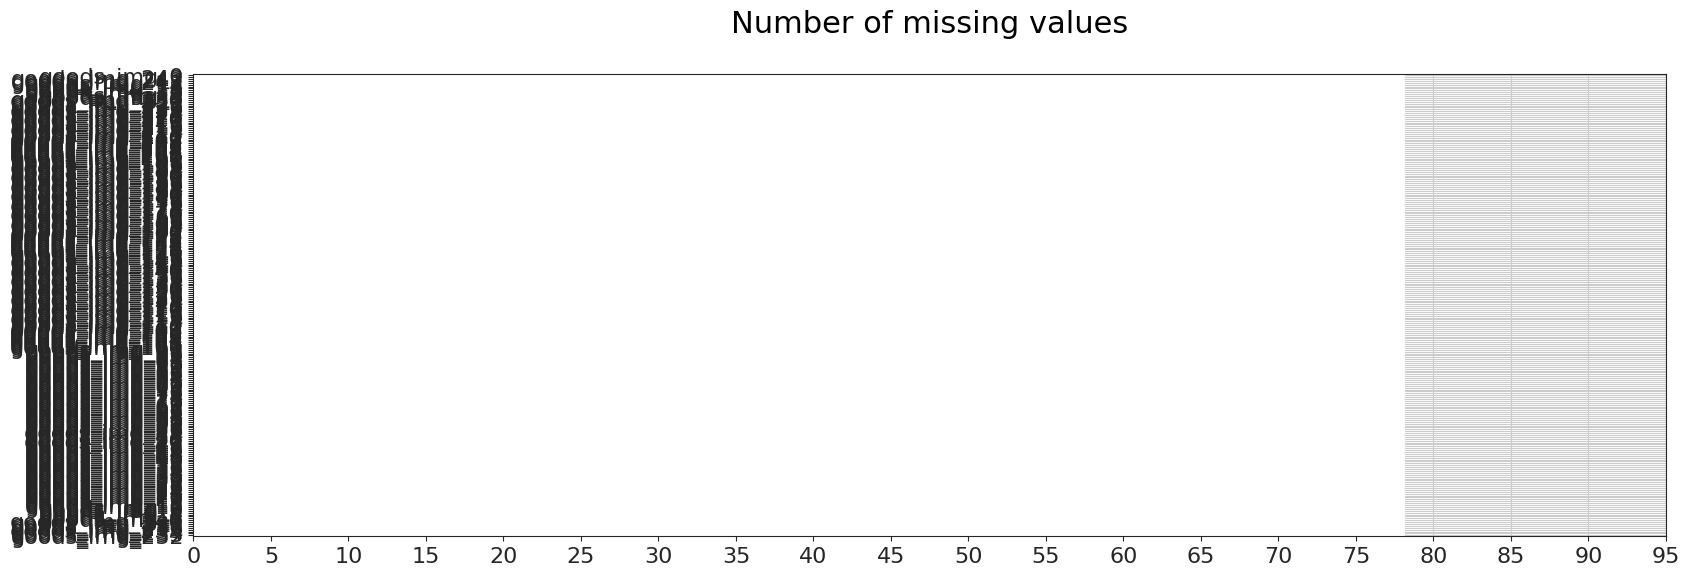

In [ ]:
# check missing values after joining
pass_value_barh(train_all)

In [ ]:
# fill all with 0
train_all.fillna(0, inplace = True)

No missing values


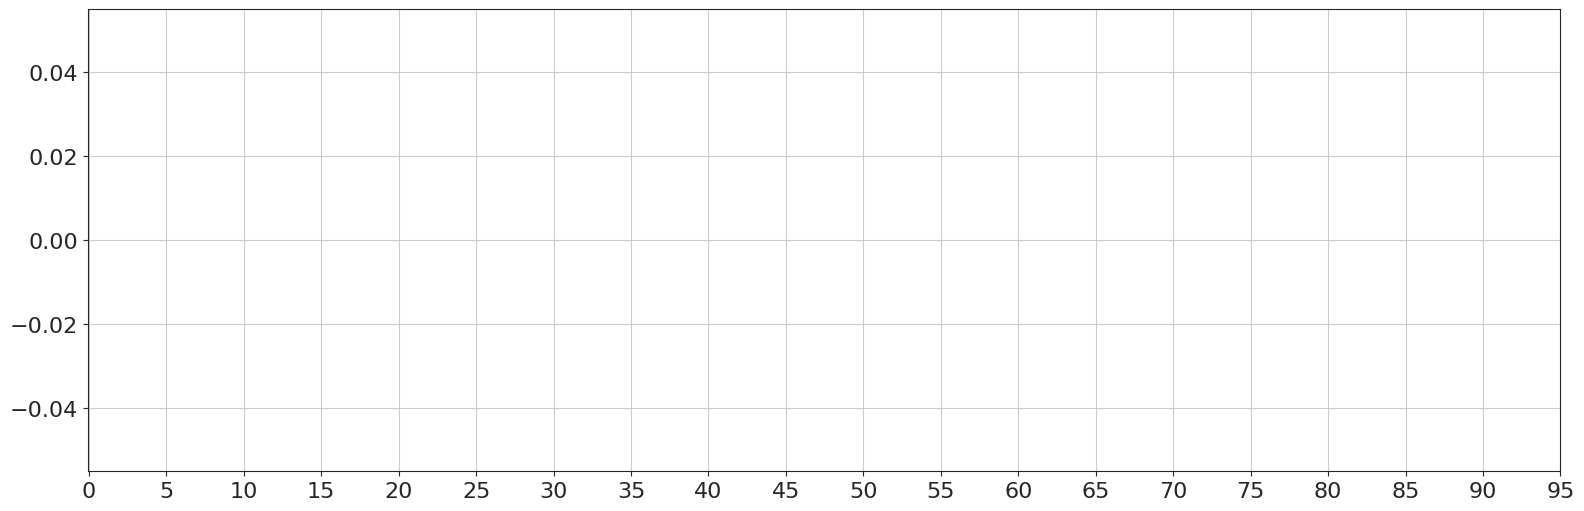

In [ ]:
pass_value_barh(train_all)

<div class="alert alert-block alert-danger">

Графики должны быть информативны, т. е. не должно быть перекрытия подписей, отсутствия данных и т. д.

</div>

After adding embeddings, our data has the following characteristics:
- 1,996,670 rows
- 627 features

# Preprocess test data

I will process the test data similarly to the training data:

- Fill missing goods_category_id with category -5.
- Fill missing values in goods_price with the median value for the corresponding goods category.
- Replace category 2463684633817211.0 with 10.
- Examine the distribution to understand what to do with outliers.
- convert 'offer_price', 'goods_price' into int format

In [ ]:
test_data = pd.read_csv('/kaggle/input/samokat-tech/test.csv')
test_data.shape

(363835, 8)

In [ ]:
test_data['id'].duplicated().sum()

0

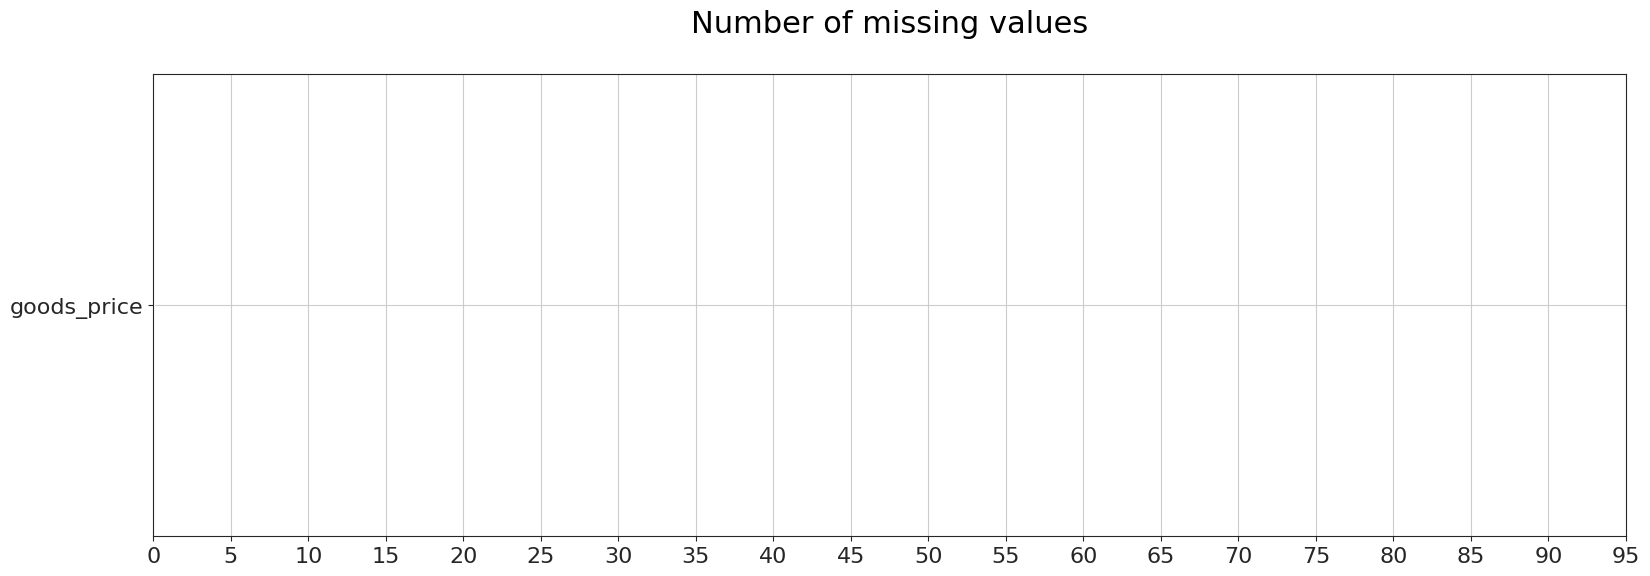

In [ ]:
# asses missing values
pass_value_barh(test_data)

In [ ]:
test_data['goods_category_id'] = test_data['goods_category_id'].fillna(-5)

In [ ]:
# replace cat which inconvinient with value 10
test_data.loc[test_data['goods_category_id'] == 2463684633817211.0, 'goods_category_id'] = 10

In [ ]:
# mapping the missing goods_price values based on their corresponding goods_category_id
# to the previously calculated median values
goods_price_filled = test_data.loc[test_data['goods_price'].isna(), 'goods_category_id'] \
                                                .map(median_price_map)
goods_price_filled.sample(10)

363795    1090.0
991       1090.0
142710    1090.0
210594    1090.0
310751    1090.0
13555     1090.0
16074     1090.0
363807    1090.0
336433    1090.0
124930    1090.0
Name: goods_category_id, dtype: float64

In [ ]:
# replace entries with NaNs with the median value
test_data.loc[test_data['goods_price'].isna(), 'goods_price'] = goods_price_filled
# check
pass_value_barh(test_data['goods_price'])

No missing values


In [ ]:
test_data[['offer_price', 'goods_price']] = test_data[['offer_price', 'goods_price']].astype('int')

In [ ]:
test_data[['goods_price']].quantile([.005, .98, .99, .9998])

,goods_price
0.0050,145.0000
0.9800,71690.0000
0.9900,106556.4000
0.9998,438688.9636


The distribution of values in the 'goods_price' feature is identical to the training set, which means we can process them identically

In [ ]:
test_data.shape

(363835, 8)

In [ ]:
# Let's add corresponding features with distance vectors for objects in the test set.
test_data['title_dist'] = np.load('/kaggle/input/test-title-distance/test_title_dist.npy')[1:]
test_data['img_dist'] = np.load('/kaggle/input/test-distances/test_dist.npy')[1:]

In [ ]:
# join embeddings
test = pd.merge(test_data, goods_title.drop_duplicates('goods_depersanalised'),
                        on = 'goods_depersanalised',
                        how = 'left')

test = pd.merge(test, offer_title.drop_duplicates('offer_depersanalised'),
                        on = 'offer_depersanalised',
                        how = 'left')

test = pd.merge(test, goods_img.drop_duplicates('goods_depersanalised'),
                          on = 'goods_depersanalised',
                          how = 'left')

test = pd.merge(test, offers_img.drop_duplicates('offer_depersanalised'),
                          on = 'offer_depersanalised',
                          how = 'left')
test.shape

(363835, 626)

In [ ]:
test.fillna(0, inplace = True)

The resulting dataframe retained the original number of rows

<div class="alert alert-block alert-danger">

Перед переходом к новому разделу имеет смысл подвести итоги анализа и предобработки.

</div>

# Machine learning

In [ ]:
# find a categorical features
train.select_dtypes(include = 'object')

,id
0,295140$1396793
1,65291$1396586
2,39232$1396244
3,39232$1396513
4,65052$1396237
...,...
2518436,464047$130193
2518437,464047$209576
2518438,4579$1163344
2518439,340842$1163356


In [ ]:
train.columns

Index(['offer_depersanalised', 'goods_depersanalised', 'sum_length',
       'attrs+title_score', 'offer_price', 'goods_price', 'goods_category_id',
       'target', 'id', 'img_dist', 'title_dist'],
      dtype='object')

In [ ]:
train_all['target'].mean()

0.11794087155113264

The sample is unbalanced, but we cannot balance it since we do not know the class balance in the test set. If we train on a balanced sample, the model may make significant errors. Therefore, for now, we leave it as is

<div class="alert alert-block alert-success">

Молодец, что обратила внимание на дисбаланс классов.

Дополнительно можно посмотреть: https://alexanderdyakonov.wordpress.com/2021/05/27/imbalance/

</div>

In [ ]:
# split the
train_idx, valid_idx = train_test_split(train_all.index,
                                shuffle = True,
                                test_size = 0.25,
                                random_state = SEED)
print(f'''
Training set size: {train_idx.shape}

Validation set size: {valid_idx.shape}
''')


Training set size: (1497502,)

Validation set size: (499168,)



I dont need scaling because i am going to use onle tree based algorithms

In [ ]:
# clean garbage variables
gc.collect()

48813

Divide the dataset into batches to optimize resource usage

In [ ]:
# Set the batch size
batch_size = 500000

# Get the number of batches
num_batches = len(train_idx) // batch_size + int(len(train_idx) % batch_size > 0)

for i in tqdm(range(0,num_batches)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_idx) else len(train_idx)
    print(start_idx, end_idx)

  0%|          | 0/3 [00:00<?, ?it/s]

0 500000
500000 1000000
1000000 1497502


### Baseline on a data without embeddings

Get the baseline without embeddings only with distances and original feature

In [ ]:
train_dist = train_all[train.columns].drop(index = valid_idx.to_list())
valid_dist = train_all[train.columns].drop(index = train_idx.to_list())
train_dist.shape

(1875000, 11)

In [ ]:
# Separate the training and target features
X = train_dist.drop(['target', 'id'], axis = 1).columns.to_list()
y = 'target'

In [ ]:
# fit
params = {'learning_rate' : 0.06,
          'eval_metric' : 'F1',
          'task_type' : 'GPU',
          'verbose' : 100,
          'random_seed' : SEED}

<div class="alert alert-block alert-success">

Отлично, baseline модель построена 👍👍👍
    
</div>

### Catboost

In [ ]:
catboost = CatBoostClassifier(**params)

# Loop over batches
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_dist) else len(train_dist)
    # Create a batch Pool
    batch_pool = Pool(data = train_dist.iloc[start_idx : end_idx][X],
                      label = train_dist.iloc[start_idx : end_idx][y])

    catboost.fit(batch_pool, eval_set = None)
    # clean garbage variables
    gc.collect()

  0%|          | 0/4 [00:00<?, ?it/s]

0:	learn: 0.6769490	total: 341ms	remaining: 5m 40s
100:	learn: 0.7892832	total: 1.36s	remaining: 12.1s
200:	learn: 0.8095876	total: 2.2s	remaining: 8.75s
300:	learn: 0.8179109	total: 3.02s	remaining: 7.01s
400:	learn: 0.8246051	total: 3.83s	remaining: 5.72s
500:	learn: 0.8291019	total: 4.65s	remaining: 4.63s
600:	learn: 0.8332607	total: 5.47s	remaining: 3.63s
700:	learn: 0.8370355	total: 6.3s	remaining: 2.69s
800:	learn: 0.8396041	total: 7.11s	remaining: 1.77s
900:	learn: 0.8434720	total: 7.94s	remaining: 872ms
999:	learn: 0.8465330	total: 8.74s	remaining: 0us
0:	learn: 0.7748700	total: 11ms	remaining: 11s
100:	learn: 0.8553984	total: 878ms	remaining: 7.81s
200:	learn: 0.8667554	total: 1.79s	remaining: 7.13s
300:	learn: 0.8734060	total: 2.64s	remaining: 6.14s
400:	learn: 0.8775345	total: 3.42s	remaining: 5.11s
500:	learn: 0.8805822	total: 4.2s	remaining: 4.18s
600:	learn: 0.8827824	total: 5s	remaining: 3.32s
700:	learn: 0.8856280	total: 5.78s	remaining: 2.47s
800:	learn: 0.8873842	tota

In [ ]:
# assess the result based on data without embeddings
y_score = catboost.predict_proba(valid_dist[X])[:,1]

  0%|          | 0/101 [00:00<?, ?it/s]

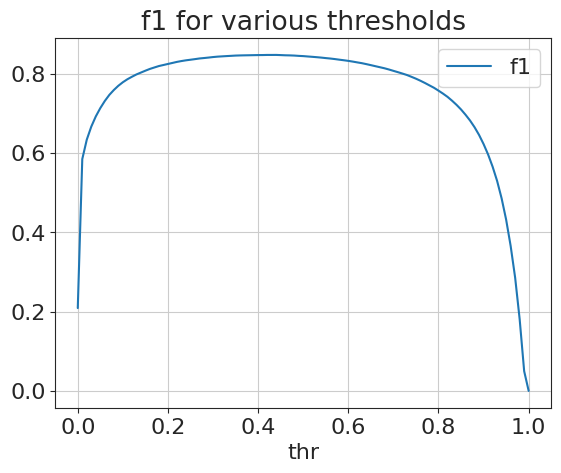

In [ ]:
# Find the best threshold
res = []

for thr in tqdm(np.linspace(0, 1, 101)):
    res.append((thr, f1_score(valid_dist[y].astype('int'), y_score > thr)))

df_f1 = pd.DataFrame(res, columns=['thr', 'f1'])
df_f1.sort_values('f1', ascending=False)

# Visualize the result
df_f1.set_index('thr').plot()
plt.title('F1 for Various Thresholds')
plt.show()

In [ ]:
df_f1.sort_values('f1', ascending = False)

,thr,f1
44,0.44,0.848323
42,0.42,0.848273
43,0.43,0.848255
41,0.41,0.847999
40,0.40,0.847941
...,...,...
97,0.97,0.285878
0,0.00,0.209197
98,0.98,0.181113
99,0.99,0.049881


In [ ]:
# clean garbage variables
gc.collect()

3616

### Light GBM

In [ ]:
!pip install lightgbm -q
import lightgbm as lgb

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [ ]:
params = {
    'objective': 'binary',
    'verbosity': -1,
    'device': 'gpu',
    'learning_rate': 0.06}

# Pass parameters
lgbm = lgb.LGBMClassifier(**params)

# Loop over batches
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_dist) else len(train_dist)

    # training set
    train_dist.iloc[start_idx : end_idx][X],
    train_dist.iloc[start_idx : end_idx][y]

    lgbm.fit(train_dist.iloc[start_idx : end_idx][X],
             train_dist.iloc[start_idx : end_idx][y])

  0%|          | 0/4 [00:00<?, ?it/s]

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


In [ ]:
valid_dist['y_score'] = lgbm.predict_proba(valid_dist[X])[:,1]

In [ ]:
# find the best threshold
res = []

for thr in tqdm(np.linspace(0,1,101)):
    res.append((thr, f1_score(valid_dist[y].astype('int'), valid_dist['y_score'] > thr)))

  0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
df_f1 = pd.DataFrame(res,columns = ['thr','f1'])
df_f1.sort_values('f1',ascending = False)

,thr,f1
40,0.40,0.844486
37,0.37,0.844426
38,0.38,0.844393
41,0.41,0.844392
39,0.39,0.844374
...,...,...
96,0.96,0.119474
97,0.97,0.013981
98,0.98,0.000000
99,0.99,0.000000


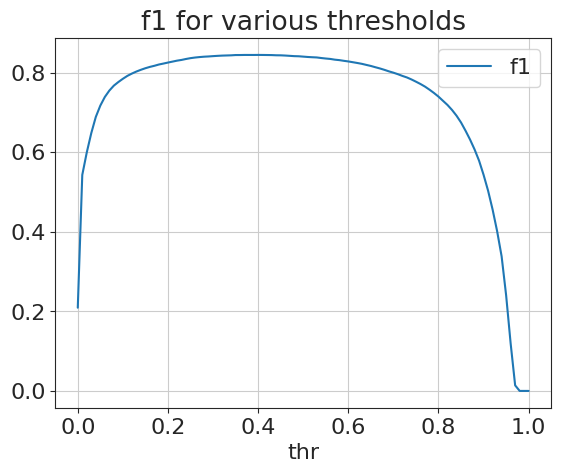

In [ ]:
# Visualize the result
df_f1.set_index('thr').plot()
plt.title('f1 for various thresholds')
plt.show()

<div class="alert alert-block alert-success">

Ок, модель построена и качество модели при различных порогах проанализировано.

</div>

## Hyperparameters tuning

In [ ]:
# Create parameters grid for optimization search
def objective(trial):

    params = {
    'eval_metric': 'F1',
    'learning_rate' : trial.suggest_float('learning_rate', 0.015, 0.15),
    'l2_leaf_reg' : trial.suggest_int('l2_leaf_reg', 1, 9),
    'task_type' : 'GPU',
    'verbose' : 100
    }

    catboost = CatBoostClassifier(**params)

    # Loop over batches
    for i in tqdm(range(num_batches)):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_idx) else len(train_idx)

        # Create a batch Pool
        batch_pool = Pool(data = train_dist.iloc[start_idx : end_idx][X],
                      label = train_dist.iloc[start_idx : end_idx][y])

        catboost.fit(batch_pool, eval_set = None)
        gc.collect()

    predictions = catboost.predict(valid_dist[X])
    score = f1_score(valid_dist[y], predictions)

    return score


In [ ]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 10)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-02-11 15:39:07,394] A new study created in memory with name: no-name-37851a75-2217-40ce-b3aa-cc03e59d3ae3


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.7997343	total: 10.2ms	remaining: 10.2s
100:	learn: 0.8512078	total: 846ms	remaining: 7.53s
200:	learn: 0.8596778	total: 1.67s	remaining: 6.63s
300:	learn: 0.8650481	total: 2.5s	remaining: 5.81s
400:	learn: 0.8682820	total: 3.35s	remaining: 5.01s
500:	learn: 0.8710535	total: 4.18s	remaining: 4.17s
600:	learn: 0.8736028	total: 5.03s	remaining: 3.34s
700:	learn: 0.8756373	total: 5.89s	remaining: 2.51s
800:	learn: 0.8777173	total: 6.76s	remaining: 1.68s
900:	learn: 0.8790501	total: 7.62s	remaining: 838ms
999:	learn: 0.8806575	total: 8.41s	remaining: 0us
0:	learn: 0.8020147	total: 8.84ms	remaining: 8.83s
100:	learn: 0.8517698	total: 837ms	remaining: 7.45s
200:	learn: 0.8602487	total: 1.68s	remaining: 6.67s
300:	learn: 0.8654385	total: 2.55s	remaining: 5.92s
400:	learn: 0.8690748	total: 3.37s	remaining: 5.03s
500:	learn: 0.8718605	total: 4.16s	remaining: 4.15s
600:	learn: 0.8740257	total: 4.99s	remaining: 3.31s
700:	learn: 0.8762717	total: 5.8s	remaining: 2.47s
800:	learn: 0.8782

[I 2024-02-11 15:39:35,763] Trial 0 finished with value: 0.8655030027459548 and parameters: {'learning_rate': 0.12410324535112867, 'l2_leaf_reg': 4}. Best is trial 0 with value: 0.8655030027459548.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.7997343	total: 8.66ms	remaining: 8.65s
100:	learn: 0.8538201	total: 820ms	remaining: 7.3s
200:	learn: 0.8621708	total: 1.63s	remaining: 6.47s
300:	learn: 0.8675276	total: 2.47s	remaining: 5.75s
400:	learn: 0.8704809	total: 3.29s	remaining: 4.92s
500:	learn: 0.8732307	total: 4.13s	remaining: 4.11s
600:	learn: 0.8755884	total: 4.95s	remaining: 3.29s
700:	learn: 0.8778001	total: 5.79s	remaining: 2.47s
800:	learn: 0.8798828	total: 6.61s	remaining: 1.64s
900:	learn: 0.8819857	total: 7.46s	remaining: 820ms
999:	learn: 0.8836958	total: 8.27s	remaining: 0us
0:	learn: 0.8020147	total: 9.49ms	remaining: 9.48s
100:	learn: 0.8540372	total: 900ms	remaining: 8.01s
200:	learn: 0.8626625	total: 1.74s	remaining: 6.93s
300:	learn: 0.8675177	total: 2.57s	remaining: 5.97s
400:	learn: 0.8711187	total: 3.36s	remaining: 5.02s
500:	learn: 0.8735362	total: 4.17s	remaining: 4.15s
600:	learn: 0.8761389	total: 5s	remaining: 3.32s
700:	learn: 0.8785511	total: 5.88s	remaining: 2.51s
800:	learn: 0.880404

[I 2024-02-11 15:40:04,228] Trial 1 finished with value: 0.866147017726513 and parameters: {'learning_rate': 0.14896166827346585, 'l2_leaf_reg': 8}. Best is trial 1 with value: 0.866147017726513.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.7997343	total: 8.84ms	remaining: 8.83s
100:	learn: 0.8504939	total: 829ms	remaining: 7.38s
200:	learn: 0.8590861	total: 1.65s	remaining: 6.55s
300:	learn: 0.8641831	total: 2.47s	remaining: 5.75s
400:	learn: 0.8675904	total: 3.29s	remaining: 4.91s
500:	learn: 0.8703034	total: 4.09s	remaining: 4.08s
600:	learn: 0.8722459	total: 4.91s	remaining: 3.26s
700:	learn: 0.8743595	total: 5.74s	remaining: 2.45s
800:	learn: 0.8764725	total: 6.57s	remaining: 1.63s
900:	learn: 0.8783919	total: 7.42s	remaining: 816ms
999:	learn: 0.8796257	total: 8.23s	remaining: 0us
0:	learn: 0.8020147	total: 9.06ms	remaining: 9.06s
100:	learn: 0.8510135	total: 830ms	remaining: 7.39s
200:	learn: 0.8590591	total: 1.66s	remaining: 6.6s
300:	learn: 0.8646827	total: 2.48s	remaining: 5.76s
400:	learn: 0.8681169	total: 3.28s	remaining: 4.89s
500:	learn: 0.8705613	total: 4.14s	remaining: 4.12s
600:	learn: 0.8728191	total: 5.02s	remaining: 3.33s
700:	learn: 0.8751911	total: 5.84s	remaining: 2.49s
800:	learn: 0.877

[I 2024-02-11 15:40:32,461] Trial 2 finished with value: 0.8656013364553807 and parameters: {'learning_rate': 0.11627239982167556, 'l2_leaf_reg': 6}. Best is trial 1 with value: 0.866147017726513.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.7997343	total: 9.18ms	remaining: 9.17s
100:	learn: 0.8426816	total: 854ms	remaining: 7.6s
200:	learn: 0.8513910	total: 1.66s	remaining: 6.59s
300:	learn: 0.8567377	total: 2.48s	remaining: 5.75s
400:	learn: 0.8604681	total: 3.29s	remaining: 4.91s
500:	learn: 0.8628498	total: 4.11s	remaining: 4.09s
600:	learn: 0.8650207	total: 4.92s	remaining: 3.27s
700:	learn: 0.8667273	total: 5.73s	remaining: 2.44s
800:	learn: 0.8686808	total: 6.53s	remaining: 1.62s
900:	learn: 0.8701215	total: 7.34s	remaining: 806ms
999:	learn: 0.8714172	total: 8.15s	remaining: 0us
0:	learn: 0.8020147	total: 8.65ms	remaining: 8.64s
100:	learn: 0.8434135	total: 828ms	remaining: 7.37s
200:	learn: 0.8525910	total: 1.65s	remaining: 6.56s
300:	learn: 0.8569779	total: 2.46s	remaining: 5.7s
400:	learn: 0.8604988	total: 3.27s	remaining: 4.88s
500:	learn: 0.8625852	total: 4.08s	remaining: 4.06s
600:	learn: 0.8653436	total: 4.9s	remaining: 3.25s
700:	learn: 0.8672884	total: 5.71s	remaining: 2.43s
800:	learn: 0.86919

[I 2024-02-11 15:41:00,530] Trial 3 finished with value: 0.8630843522038426 and parameters: {'learning_rate': 0.062016429676179194, 'l2_leaf_reg': 4}. Best is trial 1 with value: 0.866147017726513.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.7997343	total: 9.49ms	remaining: 9.48s
100:	learn: 0.8414099	total: 806ms	remaining: 7.18s
200:	learn: 0.8508223	total: 1.62s	remaining: 6.43s
300:	learn: 0.8555774	total: 2.44s	remaining: 5.67s
400:	learn: 0.8591826	total: 3.23s	remaining: 4.83s
500:	learn: 0.8619792	total: 4.04s	remaining: 4.03s
600:	learn: 0.8642789	total: 4.83s	remaining: 3.2s
700:	learn: 0.8660498	total: 5.66s	remaining: 2.41s
800:	learn: 0.8678300	total: 6.49s	remaining: 1.61s
900:	learn: 0.8693198	total: 7.31s	remaining: 803ms
999:	learn: 0.8704074	total: 8.13s	remaining: 0us
0:	learn: 0.8020147	total: 9.03ms	remaining: 9.02s
100:	learn: 0.8428273	total: 822ms	remaining: 7.31s
200:	learn: 0.8522931	total: 1.65s	remaining: 6.57s
300:	learn: 0.8568279	total: 2.47s	remaining: 5.74s
400:	learn: 0.8602597	total: 3.33s	remaining: 4.97s
500:	learn: 0.8626692	total: 4.15s	remaining: 4.13s
600:	learn: 0.8652283	total: 4.95s	remaining: 3.29s
700:	learn: 0.8670517	total: 5.75s	remaining: 2.45s
800:	learn: 0.868

[I 2024-02-11 15:41:28,791] Trial 4 finished with value: 0.8627031621664233 and parameters: {'learning_rate': 0.0613578909807847, 'l2_leaf_reg': 8}. Best is trial 1 with value: 0.866147017726513.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.7997343	total: 8.88ms	remaining: 8.88s
100:	learn: 0.8539142	total: 861ms	remaining: 7.66s
200:	learn: 0.8617178	total: 1.7s	remaining: 6.76s
300:	learn: 0.8665574	total: 2.54s	remaining: 5.89s
400:	learn: 0.8702417	total: 3.37s	remaining: 5.03s
500:	learn: 0.8729087	total: 4.2s	remaining: 4.18s
600:	learn: 0.8755485	total: 5.02s	remaining: 3.33s
700:	learn: 0.8778101	total: 5.89s	remaining: 2.51s
800:	learn: 0.8798389	total: 6.72s	remaining: 1.67s
900:	learn: 0.8816208	total: 7.53s	remaining: 827ms
999:	learn: 0.8833273	total: 8.33s	remaining: 0us
0:	learn: 0.8020147	total: 9.59ms	remaining: 9.58s
100:	learn: 0.8540274	total: 867ms	remaining: 7.72s
200:	learn: 0.8621025	total: 1.69s	remaining: 6.72s
300:	learn: 0.8674608	total: 2.49s	remaining: 5.78s
400:	learn: 0.8708954	total: 3.31s	remaining: 4.95s
500:	learn: 0.8738116	total: 4.11s	remaining: 4.1s
600:	learn: 0.8765150	total: 4.94s	remaining: 3.28s
700:	learn: 0.8789188	total: 5.74s	remaining: 2.45s
800:	learn: 0.88042

[I 2024-02-11 15:41:57,575] Trial 5 finished with value: 0.8657284972389316 and parameters: {'learning_rate': 0.14653537760200586, 'l2_leaf_reg': 9}. Best is trial 1 with value: 0.866147017726513.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.7997343	total: 8.82ms	remaining: 8.81s
100:	learn: 0.8407996	total: 828ms	remaining: 7.37s
200:	learn: 0.8500633	total: 1.67s	remaining: 6.65s
300:	learn: 0.8548661	total: 2.49s	remaining: 5.79s
400:	learn: 0.8589378	total: 3.29s	remaining: 4.91s
500:	learn: 0.8615002	total: 4.1s	remaining: 4.08s
600:	learn: 0.8639333	total: 4.92s	remaining: 3.26s
700:	learn: 0.8660335	total: 5.76s	remaining: 2.46s
800:	learn: 0.8675426	total: 6.57s	remaining: 1.63s
900:	learn: 0.8691163	total: 7.37s	remaining: 810ms
999:	learn: 0.8700746	total: 8.18s	remaining: 0us
0:	learn: 0.8020147	total: 8.98ms	remaining: 8.97s
100:	learn: 0.8422526	total: 834ms	remaining: 7.42s
200:	learn: 0.8512849	total: 1.64s	remaining: 6.53s
300:	learn: 0.8562709	total: 2.45s	remaining: 5.68s
400:	learn: 0.8598128	total: 3.25s	remaining: 4.85s
500:	learn: 0.8624076	total: 4.04s	remaining: 4.03s
600:	learn: 0.8648086	total: 4.85s	remaining: 3.22s
700:	learn: 0.8663766	total: 5.67s	remaining: 2.42s
800:	learn: 0.868

[I 2024-02-11 15:42:25,448] Trial 6 finished with value: 0.8623128804079617 and parameters: {'learning_rate': 0.05773152148208148, 'l2_leaf_reg': 4}. Best is trial 1 with value: 0.866147017726513.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.7997343	total: 10.5ms	remaining: 10.5s
100:	learn: 0.8492013	total: 831ms	remaining: 7.4s
200:	learn: 0.8579774	total: 1.64s	remaining: 6.54s
300:	learn: 0.8627404	total: 2.48s	remaining: 5.76s
400:	learn: 0.8661208	total: 3.29s	remaining: 4.92s
500:	learn: 0.8688298	total: 4.11s	remaining: 4.09s
600:	learn: 0.8712411	total: 4.98s	remaining: 3.3s
700:	learn: 0.8735275	total: 5.84s	remaining: 2.49s
800:	learn: 0.8754210	total: 6.66s	remaining: 1.65s
900:	learn: 0.8772029	total: 7.49s	remaining: 823ms
999:	learn: 0.8786505	total: 8.31s	remaining: 0us
0:	learn: 0.8020147	total: 8.91ms	remaining: 8.9s
100:	learn: 0.8500604	total: 841ms	remaining: 7.49s
200:	learn: 0.8577160	total: 1.68s	remaining: 6.66s
300:	learn: 0.8632470	total: 2.48s	remaining: 5.77s
400:	learn: 0.8665022	total: 3.32s	remaining: 4.96s
500:	learn: 0.8687410	total: 4.13s	remaining: 4.11s
600:	learn: 0.8713597	total: 4.96s	remaining: 3.29s
700:	learn: 0.8735684	total: 5.79s	remaining: 2.47s
800:	learn: 0.87558

[I 2024-02-11 15:42:54,038] Trial 7 finished with value: 0.865496915883372 and parameters: {'learning_rate': 0.10349980228786908, 'l2_leaf_reg': 5}. Best is trial 1 with value: 0.866147017726513.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.7997343	total: 8.93ms	remaining: 8.92s
100:	learn: 0.8340672	total: 861ms	remaining: 7.66s
200:	learn: 0.8447380	total: 1.68s	remaining: 6.68s
300:	learn: 0.8502576	total: 2.57s	remaining: 5.96s
400:	learn: 0.8534061	total: 3.42s	remaining: 5.11s
500:	learn: 0.8558164	total: 4.22s	remaining: 4.2s
600:	learn: 0.8584536	total: 5.03s	remaining: 3.34s
700:	learn: 0.8604184	total: 5.84s	remaining: 2.49s
800:	learn: 0.8619890	total: 6.66s	remaining: 1.65s
900:	learn: 0.8633663	total: 7.48s	remaining: 822ms
999:	learn: 0.8647308	total: 8.29s	remaining: 0us
0:	learn: 0.8020147	total: 9.41ms	remaining: 9.4s
100:	learn: 0.8339554	total: 832ms	remaining: 7.41s
200:	learn: 0.8456305	total: 1.64s	remaining: 6.52s
300:	learn: 0.8507774	total: 2.45s	remaining: 5.7s
400:	learn: 0.8542849	total: 3.27s	remaining: 4.89s
500:	learn: 0.8565396	total: 4.08s	remaining: 4.07s
600:	learn: 0.8585557	total: 4.91s	remaining: 3.26s
700:	learn: 0.8603678	total: 5.72s	remaining: 2.44s
800:	learn: 0.86238

[I 2024-02-11 15:43:22,131] Trial 8 finished with value: 0.8596410618643662 and parameters: {'learning_rate': 0.03693540942877927, 'l2_leaf_reg': 5}. Best is trial 1 with value: 0.866147017726513.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.7997343	total: 9.35ms	remaining: 9.34s
100:	learn: 0.8519035	total: 948ms	remaining: 8.44s
200:	learn: 0.8606141	total: 1.76s	remaining: 7.01s
300:	learn: 0.8656883	total: 2.58s	remaining: 6s
400:	learn: 0.8690804	total: 3.41s	remaining: 5.1s
500:	learn: 0.8720955	total: 4.23s	remaining: 4.22s
600:	learn: 0.8743732	total: 5.04s	remaining: 3.35s
700:	learn: 0.8763679	total: 5.86s	remaining: 2.5s
800:	learn: 0.8783176	total: 6.75s	remaining: 1.68s
900:	learn: 0.8801419	total: 7.57s	remaining: 832ms
999:	learn: 0.8815863	total: 8.39s	remaining: 0us
0:	learn: 0.8020147	total: 8.83ms	remaining: 8.82s
100:	learn: 0.8527133	total: 846ms	remaining: 7.53s
200:	learn: 0.8612193	total: 1.69s	remaining: 6.7s
300:	learn: 0.8658890	total: 2.52s	remaining: 5.84s
400:	learn: 0.8696832	total: 3.31s	remaining: 4.95s
500:	learn: 0.8723302	total: 4.13s	remaining: 4.11s
600:	learn: 0.8746854	total: 4.94s	remaining: 3.28s
700:	learn: 0.8771984	total: 5.75s	remaining: 2.45s
800:	learn: 0.8794572	

[I 2024-02-11 15:43:50,552] Trial 9 finished with value: 0.8659154389616079 and parameters: {'learning_rate': 0.13382984908480053, 'l2_leaf_reg': 7}. Best is trial 1 with value: 0.866147017726513.


Best Hyperparameters: {'learning_rate': 0.14896166827346585, 'l2_leaf_reg': 8}


In [ ]:
best_params

{'learning_rate': 0.14896166827346585, 'l2_leaf_reg': 8}

<div class="alert alert-block alert-success">

Отлично, наилучшие значения гиперпараметров подобраны:)
    
Дополнительно про подбор гиперпараметров можно посмотреть: https://habr.com/ru/articles/563494/

</div>

In [ ]:
params = { 'eval_metric': 'F1', 'learning_rate' : 0.14195152908399983, 'l2_leaf_reg' : 6, 'task_type' : 'GPU', 'verbose' : 100 }

In [ ]:
catboost = CatBoostClassifier(**params)

# Loop over batches
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_dist) else len(train_dist)

    # Create a batch Pool
    batch_pool = Pool(data = train_dist.iloc[start_idx : end_idx][X],
                      label = train_dist.iloc[start_idx : end_idx][y])

    catboost.fit(batch_pool, eval_set = None)
    gc.collect()


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.7997343	total: 8.93ms	remaining: 8.92s
100:	learn: 0.8516610	total: 819ms	remaining: 7.29s
200:	learn: 0.8615556	total: 1.65s	remaining: 6.54s
300:	learn: 0.8668953	total: 2.51s	remaining: 5.82s
400:	learn: 0.8698082	total: 3.34s	remaining: 4.99s
500:	learn: 0.8724992	total: 4.18s	remaining: 4.17s
600:	learn: 0.8747515	total: 5.01s	remaining: 3.33s
700:	learn: 0.8771049	total: 5.87s	remaining: 2.5s
800:	learn: 0.8795429	total: 6.68s	remaining: 1.66s
900:	learn: 0.8815023	total: 7.5s	remaining: 824ms
999:	learn: 0.8831652	total: 8.29s	remaining: 0us
0:	learn: 0.8020147	total: 10.9ms	remaining: 10.9s
100:	learn: 0.8535352	total: 914ms	remaining: 8.14s
200:	learn: 0.8617728	total: 1.73s	remaining: 6.87s
300:	learn: 0.8670895	total: 2.53s	remaining: 5.87s
400:	learn: 0.8706086	total: 3.35s	remaining: 5s
500:	learn: 0.8732136	total: 4.19s	remaining: 4.17s
600:	learn: 0.8759249	total: 5s	remaining: 3.32s
700:	learn: 0.8782775	total: 5.82s	remaining: 2.48s
800:	learn: 0.8803497	to

In [ ]:
valid_dist['y_score'] = catboost.predict_proba(valid_dist[X])[:,1]
# find the best threshold
res = []

for thr in tqdm(np.linspace(0,1,101)):
    res.append((thr,f1_score(valid_dist[y].astype('int'), valid_dist['y_score'] > thr)))


  0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
df_f1 = pd.DataFrame(res,columns = ['thr','f1'])
df_f1.sort_values('f1',ascending = False)


,thr,f1
44,0.44,0.868007
45,0.45,0.867945
43,0.43,0.867867
46,0.46,0.867744
42,0.42,0.867622
...,...,...
97,0.97,0.341235
98,0.98,0.224801
0,0.00,0.209197
99,0.99,0.082072


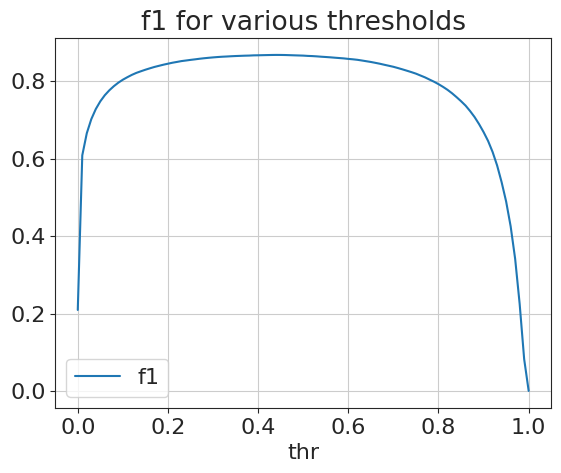

In [ ]:
# Visualize the result

df_f1.set_index('thr').plot()
plt.title('f1 for various thresholds')
plt.show()

In [ ]:
# Find the best threshold
best_thr_idx = df_f1.sort_values('f1', ascending = False)['thr'].head(1).index
thr = float(df_f1.iloc[best_thr_idx]['thr'])
thr

/tmp/ipykernel_34/185519335.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  thr = float(df_f1.iloc[best_thr_idx]['thr'])


0.44

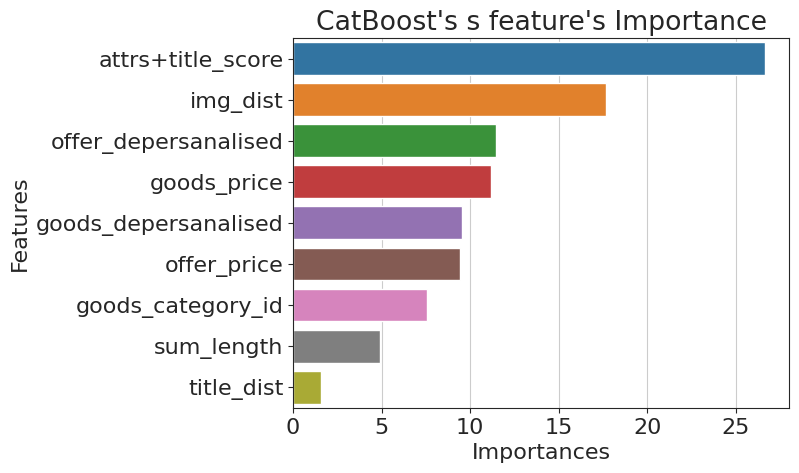

In [ ]:
# Analyze feature importance
# Train a model to extract feature importance

catboost_feature_importance = catboost.get_feature_importance(prettified=True)
catboost_feature_importance.columns = ['Features','Importances']
# Plot the graph
sns.barplot(catboost_feature_importance.sort_values(by='Importances', ascending=False).head(20), x='Importances', y='Features')
plt.title("CatBoost's Feature Importance")
plt.show()


We see that image embeddings provide more hints for our model, so let's add them and see the result.

<div class="alert alert-block alert-success">

Важность признаков определена и вывод сфомулирован:)

</div>

In [ ]:
# Delete variables to free up resources
del train_dist
del valid_dist

# With image embeddings

The outcome is just fine, so I added image vectors to see the result with those features

In [ ]:
img_columns = train.columns.to_list() + offers_image_names + goods_image_names
tit_columns = train.columns.to_list() + offers_title_names + goods_title_names

In [ ]:
train_img = train_all[img_columns].drop(index = valid_idx)
valid_img = train_all[img_columns].drop(index = train_idx)
train_img.shape

(1875000, 499)

No missing values


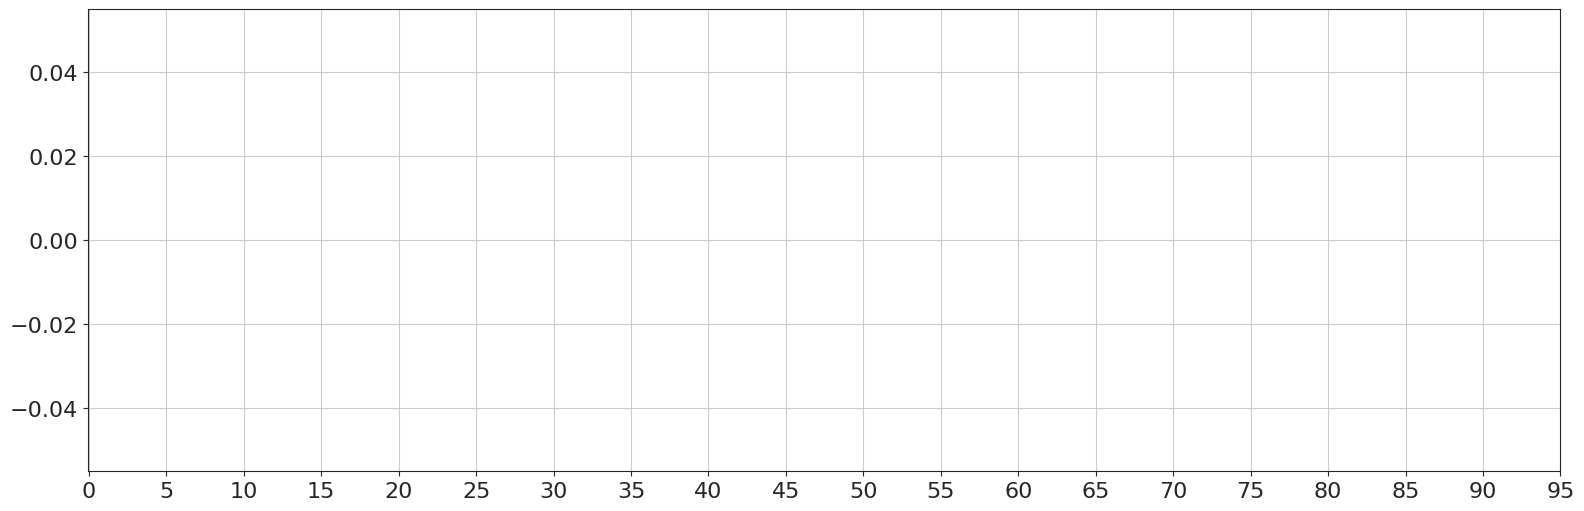

In [ ]:
pass_value_barh(train_img)

<div class="alert alert-block alert-danger">

Здесь что-то не то с графиков, данные не отображаются(

</div>

In [ ]:
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_idx) else len(train_idx)
    print(start_idx, end_idx)


  0%|          | 0/4 [00:00<?, ?it/s]

0 500000
500000 1000000
1000000 1500000
1500000 1875000


In [ ]:
X = train_img.drop(['target', 'id'], axis = 1).columns.to_list()

In [ ]:
# fit
params = {'learning_rate' : 0.06,
          'eval_metric' : 'F1',
          'task_type' : 'GPU',
          'verbose' : 100,
          'random_seed' : SEED}

catboost = CatBoostClassifier(**params)

# Loop over batches
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_idx) else len(train_idx)
    # Create a batch Pool
    batch_pool = Pool(data = train_img.iloc[start_idx : end_idx][X],
                      label = train_img.iloc[start_idx : end_idx][y])

    catboost.fit(batch_pool, eval_set = None)
    # clean garbage variables
    gc.collect()

  0%|          | 0/4 [00:00<?, ?it/s]

0:	learn: 0.9071398	total: 40.1ms	remaining: 40.1s
100:	learn: 0.9166490	total: 2.18s	remaining: 19.4s
200:	learn: 0.9214682	total: 4.21s	remaining: 16.7s
300:	learn: 0.9252955	total: 6.19s	remaining: 14.4s
400:	learn: 0.9291700	total: 8.17s	remaining: 12.2s
500:	learn: 0.9327133	total: 10.2s	remaining: 10.1s
600:	learn: 0.9351834	total: 12.2s	remaining: 8.1s
700:	learn: 0.9393304	total: 14.3s	remaining: 6.09s
800:	learn: 0.9421495	total: 16.4s	remaining: 4.06s
900:	learn: 0.9450413	total: 18.5s	remaining: 2.03s
999:	learn: 0.9474565	total: 20.6s	remaining: 0us
0:	learn: 0.9261787	total: 50.1ms	remaining: 50s
100:	learn: 0.9326984	total: 2.43s	remaining: 21.7s
200:	learn: 0.9356560	total: 4.54s	remaining: 18s
300:	learn: 0.9377906	total: 6.67s	remaining: 15.5s
400:	learn: 0.9396588	total: 8.71s	remaining: 13s
500:	learn: 0.9415636	total: 10.7s	remaining: 10.7s
600:	learn: 0.9433028	total: 12.8s	remaining: 8.49s
700:	learn: 0.9445552	total: 14.8s	remaining: 6.31s
800:	learn: 0.9460009	t

add all embeddings to see the result

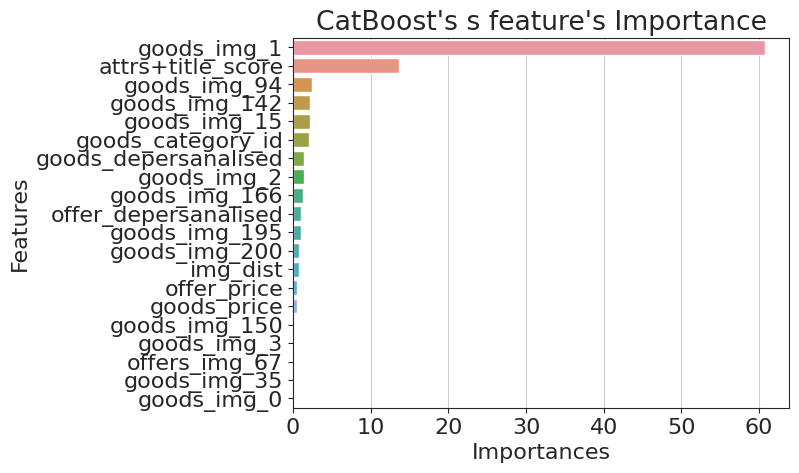

In [ ]:
# Analyze feature importance
# Train a model to extract feature importance

catboost_feature_importance = catboost.get_feature_importance(prettified=True)
catboost_feature_importance.columns = ['Features','Importances']
# Plot the graph
sns.barplot(catboost_feature_importance.sort_values(by='Importances', ascending=False).head(20), x='Importances', y='Features')
plt.title("CatBoost's Feature Importance")
plt.show()


  0%|          | 0/101 [00:00<?, ?it/s]

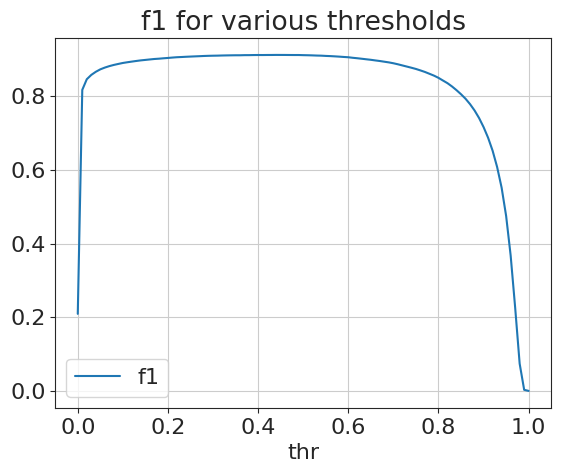

In [ ]:
valid_img['y_score'] = catboost.predict_proba(valid_img[X])[:,1]
# find the best threshold
res = []

for thr in tqdm(np.linspace(0,1,101)):
    res.append((thr,f1_score(valid_img[y].astype('int'), valid_img['y_score'] > thr)))
df_f1 = pd.DataFrame(res,columns = ['thr','f1'])

# Visualize the result
df_f1.set_index('thr').plot()
plt.title('f1 for various thresholds')
plt.show()

In [ ]:
df_f1.sort_values('f1',ascending = False)

,thr,f1
44,0.44,0.912103
45,0.45,0.912051
46,0.46,0.912016
43,0.43,0.911957
42,0.42,0.911928
...,...,...
97,0.97,0.226543
0,0.00,0.209197
98,0.98,0.074015
99,0.99,0.003009


In [ ]:
# Delete variables to free up resources
del train_img
del valid_img

# With all embeddings

In [ ]:
# create a data wich includes all embeddings
train_all_emb = train_all.drop(index = valid_idx)
valid_all_emb = train_all.drop(index = train_idx)
train_all_emb.shape

(1497502, 627)

In [ ]:
# features
X = train_all_emb.drop(['target', 'id'], axis = 1).columns.to_list()

In [ ]:
gc.collect()

63150

In [ ]:
# fit
params = {'learning_rate' : 0.06,
          'eval_metric' : 'F1',
          'task_type' : 'GPU',
          'verbose' : 100,
          'random_seed' : SEED}

catboost = CatBoostClassifier(**params)

# Loop over batches
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_idx) else len(train_idx)
    # Create a batch Pool
    batch_pool = Pool(data = train_all_emb.iloc[start_idx : end_idx][X],
                      label = train_all_emb.iloc[start_idx : end_idx][y])

    catboost.fit(batch_pool, eval_set = None)
    # clean garbage variables
    gc.collect()

  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9088943	total: 379ms	remaining: 6m 18s
100:	learn: 0.9158723	total: 2.88s	remaining: 25.6s
200:	learn: 0.9202553	total: 5.1s	remaining: 20.3s
300:	learn: 0.9236478	total: 7.3s	remaining: 16.9s
400:	learn: 0.9266277	total: 9.53s	remaining: 14.2s
500:	learn: 0.9293784	total: 11.7s	remaining: 11.7s
600:	learn: 0.9327246	total: 13.9s	remaining: 9.26s
700:	learn: 0.9355486	total: 16.2s	remaining: 6.89s
800:	learn: 0.9384903	total: 18.3s	remaining: 4.55s
900:	learn: 0.9413746	total: 20.7s	remaining: 2.27s
999:	learn: 0.9447933	total: 23s	remaining: 0us
0:	learn: 0.9172189	total: 42.4ms	remaining: 42.4s
100:	learn: 0.9260348	total: 2.52s	remaining: 22.5s
200:	learn: 0.9293383	total: 4.85s	remaining: 19.3s
300:	learn: 0.9317154	total: 7.17s	remaining: 16.6s
400:	learn: 0.9335125	total: 9.61s	remaining: 14.4s
500:	learn: 0.9354537	total: 12s	remaining: 11.9s
600:	learn: 0.9371187	total: 14.3s	remaining: 9.51s
700:	learn: 0.9385916	total: 16.6s	remaining: 7.09s
800:	learn: 0.9400611	

  0%|          | 0/101 [00:00<?, ?it/s]

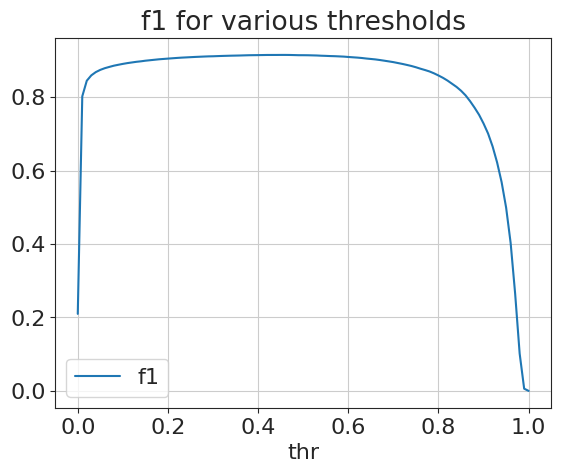

In [ ]:
valid_all_emb['y_score'] = catboost.predict_proba(valid_all_emb[X])[:,1]
# find the best threshold
res = []

for thr in tqdm(np.linspace(0,1,101)):
    res.append((thr,f1_score(valid_all_emb[y].astype('int'), valid_all_emb['y_score'] > thr)))
    df_f1 = pd.DataFrame(res,columns = ['thr','f1'])


# Visualize the result
df_f1.set_index('thr').plot()
plt.title('f1 for various thresholds')
plt.show()

In [ ]:
df_f1.sort_values('f1',ascending = False)

,thr,f1
46,0.46,0.914656
45,0.45,0.914648
44,0.44,0.914560
43,0.43,0.914540
42,0.42,0.914538
...,...,...
97,0.97,0.264638
0,0.00,0.209728
98,0.98,0.101630
99,0.99,0.006103


In [ ]:
gc.collect()

3534

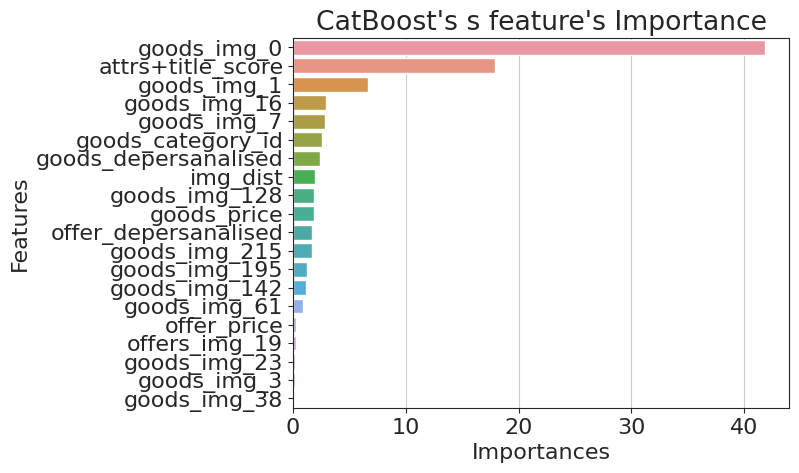

In [ ]:
# Analyze feature importance
# Train a model to extract feature importance

catboost_feature_importance = catboost.get_feature_importance(prettified=True)
catboost_feature_importance.columns = ['Features','Importances']
# Plot the graph
sns.barplot(catboost_feature_importance.sort_values(by='Importances', ascending=False).head(20), x='Importances', y='Features')
plt.title("CatBoost's Feature Importance")
plt.show()


We observe that, in addition to the 'attrs + title score' feature, the model also utilizes another feature related to the product image.

<div class="alert alert-block alert-success">

👍👍👍

</div>

In [ ]:
# Create parameter's  grid for optimization search

def objective(trial):

    params = {
    'eval_metric': 'F1',
    'learning_rate' : trial.suggest_float('learning_rate', 0.015, 0.15),
    'l2_leaf_reg' : trial.suggest_int('l2_leaf_reg', 1, 9),
    'task_type' : 'GPU',
    'verbose' : 100
    }

    catboost = CatBoostClassifier(**params)

    # Loop over batches
    for i in tqdm(range(num_batches)):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_idx) else len(train_idx)

        # Create a batch Pool
        batch_pool = Pool(data = train_all_emb.iloc[start_idx : end_idx][X],
                      label = train_all_emb.iloc[start_idx : end_idx][y])

        catboost.fit(batch_pool, eval_set = None)
        gc.collect()

    predictions = catboost.predict(valid_all_emb[X])
    score = f1_score(valid_all_emb[y], predictions)

    return score
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 25)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-02-11 19:02:51,050] A new study created in memory with name: no-name-d8a776bb-6fb7-4c52-aa55-f4c1963c330e


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 41.7ms	remaining: 41.7s
100:	learn: 0.9175922	total: 2.44s	remaining: 21.7s
200:	learn: 0.9234156	total: 4.77s	remaining: 19s
300:	learn: 0.9283937	total: 7.17s	remaining: 16.7s
400:	learn: 0.9334265	total: 9.49s	remaining: 14.2s
500:	learn: 0.9376809	total: 11.7s	remaining: 11.7s
600:	learn: 0.9416277	total: 14s	remaining: 9.27s
700:	learn: 0.9456343	total: 16.2s	remaining: 6.92s
800:	learn: 0.9494185	total: 18.6s	remaining: 4.62s
900:	learn: 0.9529232	total: 20.9s	remaining: 2.29s
999:	learn: 0.9561282	total: 23.2s	remaining: 0us
0:	learn: 0.9160716	total: 44.1ms	remaining: 44.1s
100:	learn: 0.9280368	total: 2.61s	remaining: 23.2s
200:	learn: 0.9314455	total: 5.05s	remaining: 20.1s
300:	learn: 0.9344616	total: 7.48s	remaining: 17.4s
400:	learn: 0.9369495	total: 9.94s	remaining: 14.8s
500:	learn: 0.9393124	total: 12.4s	remaining: 12.3s
600:	learn: 0.9410118	total: 14.7s	remaining: 9.77s
700:	learn: 0.9430644	total: 17.1s	remaining: 7.31s
800:	learn: 0.944810

[I 2024-02-11 19:04:32,333] Trial 0 finished with value: 0.9138158714339104 and parameters: {'learning_rate': 0.08691188335713004, 'l2_leaf_reg': 2}. Best is trial 0 with value: 0.9138158714339104.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 40.9ms	remaining: 40.9s
100:	learn: 0.9146808	total: 2.64s	remaining: 23.5s
200:	learn: 0.9183131	total: 5.01s	remaining: 19.9s
300:	learn: 0.9213775	total: 7.24s	remaining: 16.8s
400:	learn: 0.9241229	total: 9.51s	remaining: 14.2s
500:	learn: 0.9263363	total: 11.7s	remaining: 11.7s
600:	learn: 0.9287126	total: 13.9s	remaining: 9.25s
700:	learn: 0.9312440	total: 16.2s	remaining: 6.9s
800:	learn: 0.9332867	total: 18.5s	remaining: 4.59s
900:	learn: 0.9356111	total: 20.8s	remaining: 2.29s
999:	learn: 0.9373890	total: 23.1s	remaining: 0us
0:	learn: 0.9160716	total: 45.1ms	remaining: 45s
100:	learn: 0.9246482	total: 2.78s	remaining: 24.7s
200:	learn: 0.9278588	total: 5.44s	remaining: 21.6s
300:	learn: 0.9300042	total: 7.9s	remaining: 18.3s
400:	learn: 0.9318503	total: 10.4s	remaining: 15.5s
500:	learn: 0.9333293	total: 12.8s	remaining: 12.7s
600:	learn: 0.9346506	total: 15.2s	remaining: 10.1s
700:	learn: 0.9359237	total: 17.6s	remaining: 7.51s
800:	learn: 0.937387

[I 2024-02-11 19:06:15,602] Trial 1 finished with value: 0.9137032240927051 and parameters: {'learning_rate': 0.04652564023901341, 'l2_leaf_reg': 5}. Best is trial 0 with value: 0.9138158714339104.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 39.6ms	remaining: 39.6s
100:	learn: 0.9148985	total: 2.47s	remaining: 22s
200:	learn: 0.9189102	total: 4.78s	remaining: 19s
300:	learn: 0.9220716	total: 7.07s	remaining: 16.4s
400:	learn: 0.9259844	total: 9.35s	remaining: 14s
500:	learn: 0.9284103	total: 11.6s	remaining: 11.6s
600:	learn: 0.9311517	total: 13.9s	remaining: 9.26s
700:	learn: 0.9333737	total: 16.3s	remaining: 6.93s
800:	learn: 0.9354997	total: 18.6s	remaining: 4.62s
900:	learn: 0.9377028	total: 21s	remaining: 2.31s
999:	learn: 0.9395603	total: 23.4s	remaining: 0us
0:	learn: 0.9160716	total: 44.3ms	remaining: 44.2s
100:	learn: 0.9259035	total: 2.72s	remaining: 24.2s
200:	learn: 0.9289548	total: 5.19s	remaining: 20.6s
300:	learn: 0.9309157	total: 7.64s	remaining: 17.7s
400:	learn: 0.9327228	total: 10s	remaining: 14.9s
500:	learn: 0.9344171	total: 12.4s	remaining: 12.4s
600:	learn: 0.9359209	total: 14.8s	remaining: 9.8s
700:	learn: 0.9374002	total: 17.3s	remaining: 7.36s
800:	learn: 0.9387224	total

[I 2024-02-11 19:07:59,342] Trial 2 finished with value: 0.9138834234099608 and parameters: {'learning_rate': 0.05583075615682284, 'l2_leaf_reg': 9}. Best is trial 2 with value: 0.9138834234099608.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 39.8ms	remaining: 39.7s
100:	learn: 0.9189739	total: 2.5s	remaining: 22.3s
200:	learn: 0.9264986	total: 4.75s	remaining: 18.9s
300:	learn: 0.9317007	total: 7.07s	remaining: 16.4s
400:	learn: 0.9367952	total: 9.43s	remaining: 14.1s
500:	learn: 0.9408681	total: 11.8s	remaining: 11.8s
600:	learn: 0.9449941	total: 14.2s	remaining: 9.42s
700:	learn: 0.9490132	total: 16.4s	remaining: 7.01s
800:	learn: 0.9524818	total: 18.7s	remaining: 4.65s
900:	learn: 0.9562407	total: 21.2s	remaining: 2.33s
999:	learn: 0.9598110	total: 23.5s	remaining: 0us
0:	learn: 0.9160716	total: 44.4ms	remaining: 44.3s
100:	learn: 0.9288336	total: 2.62s	remaining: 23.3s
200:	learn: 0.9333900	total: 5.01s	remaining: 19.9s
300:	learn: 0.9367202	total: 7.36s	remaining: 17.1s
400:	learn: 0.9392393	total: 9.75s	remaining: 14.6s
500:	learn: 0.9416072	total: 12.2s	remaining: 12.1s
600:	learn: 0.9437540	total: 14.5s	remaining: 9.65s
700:	learn: 0.9459109	total: 16.9s	remaining: 7.22s
800:	learn: 0.947

[I 2024-02-11 19:09:41,270] Trial 3 finished with value: 0.9143948515673657 and parameters: {'learning_rate': 0.11876711282392328, 'l2_leaf_reg': 8}. Best is trial 3 with value: 0.9143948515673657.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 40.6ms	remaining: 40.6s
100:	learn: 0.9214206	total: 2.41s	remaining: 21.5s
200:	learn: 0.9289818	total: 4.64s	remaining: 18.5s
300:	learn: 0.9353529	total: 6.9s	remaining: 16s
400:	learn: 0.9414489	total: 9.24s	remaining: 13.8s
500:	learn: 0.9470399	total: 11.5s	remaining: 11.4s
600:	learn: 0.9514421	total: 13.8s	remaining: 9.13s
700:	learn: 0.9556687	total: 16.1s	remaining: 6.88s
800:	learn: 0.9600662	total: 18.5s	remaining: 4.6s
900:	learn: 0.9637082	total: 20.9s	remaining: 2.3s
999:	learn: 0.9667932	total: 23.2s	remaining: 0us
0:	learn: 0.9160716	total: 42.6ms	remaining: 42.5s
100:	learn: 0.9298796	total: 2.52s	remaining: 22.4s
200:	learn: 0.9345864	total: 4.87s	remaining: 19.4s
300:	learn: 0.9383189	total: 7.25s	remaining: 16.8s
400:	learn: 0.9416303	total: 9.61s	remaining: 14.4s
500:	learn: 0.9440625	total: 11.9s	remaining: 11.9s
600:	learn: 0.9466937	total: 14.3s	remaining: 9.47s
700:	learn: 0.9492045	total: 16.7s	remaining: 7.12s
800:	learn: 0.9513135

[I 2024-02-11 19:11:22,540] Trial 4 finished with value: 0.9142462998512461 and parameters: {'learning_rate': 0.14831825654357816, 'l2_leaf_reg': 8}. Best is trial 3 with value: 0.9143948515673657.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 40.8ms	remaining: 40.8s
100:	learn: 0.9199111	total: 2.47s	remaining: 22s
200:	learn: 0.9280071	total: 4.76s	remaining: 18.9s
300:	learn: 0.9344396	total: 6.98s	remaining: 16.2s
400:	learn: 0.9393451	total: 9.27s	remaining: 13.9s
500:	learn: 0.9447582	total: 11.7s	remaining: 11.7s
600:	learn: 0.9499412	total: 14.1s	remaining: 9.37s
700:	learn: 0.9531143	total: 16.5s	remaining: 7.03s
800:	learn: 0.9571371	total: 18.8s	remaining: 4.68s
900:	learn: 0.9603233	total: 21.1s	remaining: 2.32s
999:	learn: 0.9633362	total: 23.4s	remaining: 0us
0:	learn: 0.9160716	total: 44.3ms	remaining: 44.3s
100:	learn: 0.9295982	total: 2.55s	remaining: 22.7s
200:	learn: 0.9344353	total: 4.92s	remaining: 19.5s
300:	learn: 0.9375732	total: 7.21s	remaining: 16.8s
400:	learn: 0.9406269	total: 9.6s	remaining: 14.3s
500:	learn: 0.9428306	total: 12s	remaining: 12s
600:	learn: 0.9452914	total: 14.4s	remaining: 9.56s
700:	learn: 0.9477577	total: 16.8s	remaining: 7.16s
800:	learn: 0.9499367	t

[I 2024-02-11 19:13:04,163] Trial 5 finished with value: 0.9140056487788669 and parameters: {'learning_rate': 0.13638145208929864, 'l2_leaf_reg': 8}. Best is trial 3 with value: 0.9143948515673657.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 40.9ms	remaining: 40.9s
100:	learn: 0.9194370	total: 2.44s	remaining: 21.7s
200:	learn: 0.9262415	total: 4.74s	remaining: 18.9s
300:	learn: 0.9328459	total: 7.11s	remaining: 16.5s
400:	learn: 0.9388213	total: 9.34s	remaining: 14s
500:	learn: 0.9439828	total: 11.6s	remaining: 11.5s
600:	learn: 0.9484130	total: 13.8s	remaining: 9.19s
700:	learn: 0.9532877	total: 16.1s	remaining: 6.87s
800:	learn: 0.9572186	total: 18.4s	remaining: 4.56s
900:	learn: 0.9617293	total: 20.6s	remaining: 2.27s
999:	learn: 0.9652120	total: 22.8s	remaining: 0us
0:	learn: 0.9160716	total: 44.7ms	remaining: 44.7s
100:	learn: 0.9285487	total: 2.59s	remaining: 23s
200:	learn: 0.9331473	total: 5.05s	remaining: 20.1s
300:	learn: 0.9361156	total: 7.48s	remaining: 17.4s
400:	learn: 0.9390715	total: 9.89s	remaining: 14.8s
500:	learn: 0.9415898	total: 12.2s	remaining: 12.2s
600:	learn: 0.9439555	total: 14.6s	remaining: 9.67s
700:	learn: 0.9458451	total: 16.9s	remaining: 7.22s
800:	learn: 0.948073

[I 2024-02-11 19:14:45,323] Trial 6 finished with value: 0.9145596703031914 and parameters: {'learning_rate': 0.10596027341594856, 'l2_leaf_reg': 1}. Best is trial 6 with value: 0.9145596703031914.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 41.5ms	remaining: 41.5s
100:	learn: 0.9180085	total: 2.58s	remaining: 23s
200:	learn: 0.9246285	total: 5.1s	remaining: 20.3s
300:	learn: 0.9296606	total: 7.5s	remaining: 17.4s
400:	learn: 0.9334700	total: 9.83s	remaining: 14.7s
500:	learn: 0.9381552	total: 12.2s	remaining: 12.2s
600:	learn: 0.9416415	total: 14.6s	remaining: 9.69s
700:	learn: 0.9457699	total: 17s	remaining: 7.24s
800:	learn: 0.9493531	total: 19.4s	remaining: 4.82s
900:	learn: 0.9525489	total: 21.7s	remaining: 2.39s
999:	learn: 0.9553786	total: 24.1s	remaining: 0us
0:	learn: 0.9160716	total: 44.4ms	remaining: 44.4s
100:	learn: 0.9282312	total: 2.69s	remaining: 23.9s
200:	learn: 0.9319908	total: 5.14s	remaining: 20.4s
300:	learn: 0.9348648	total: 7.52s	remaining: 17.5s
400:	learn: 0.9375480	total: 9.89s	remaining: 14.8s
500:	learn: 0.9396154	total: 12.2s	remaining: 12.2s
600:	learn: 0.9415471	total: 14.6s	remaining: 9.68s
700:	learn: 0.9437769	total: 17s	remaining: 7.26s
800:	learn: 0.9455374	to

[I 2024-02-11 19:16:30,009] Trial 7 finished with value: 0.9147338284718477 and parameters: {'learning_rate': 0.09278986198955744, 'l2_leaf_reg': 4}. Best is trial 7 with value: 0.9147338284718477.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 40.2ms	remaining: 40.2s
100:	learn: 0.9178047	total: 2.46s	remaining: 21.9s
200:	learn: 0.9237583	total: 4.75s	remaining: 18.9s
300:	learn: 0.9284701	total: 6.97s	remaining: 16.2s
400:	learn: 0.9334296	total: 9.2s	remaining: 13.7s
500:	learn: 0.9377861	total: 11.4s	remaining: 11.4s
600:	learn: 0.9416142	total: 13.7s	remaining: 9.08s
700:	learn: 0.9454486	total: 15.9s	remaining: 6.78s
800:	learn: 0.9488010	total: 18.1s	remaining: 4.51s
900:	learn: 0.9524526	total: 20.4s	remaining: 2.25s
999:	learn: 0.9558093	total: 22.8s	remaining: 0us
0:	learn: 0.9160716	total: 44.3ms	remaining: 44.3s
100:	learn: 0.9279651	total: 2.67s	remaining: 23.7s
200:	learn: 0.9316648	total: 5.04s	remaining: 20.1s
300:	learn: 0.9344018	total: 7.43s	remaining: 17.3s
400:	learn: 0.9370258	total: 9.79s	remaining: 14.6s
500:	learn: 0.9393553	total: 12.1s	remaining: 12s
600:	learn: 0.9412427	total: 14.4s	remaining: 9.54s
700:	learn: 0.9432550	total: 16.7s	remaining: 7.12s
800:	learn: 0.94519

[I 2024-02-11 19:18:10,295] Trial 8 finished with value: 0.9144190526805288 and parameters: {'learning_rate': 0.08879418469640564, 'l2_leaf_reg': 3}. Best is trial 7 with value: 0.9147338284718477.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 40.5ms	remaining: 40.5s
100:	learn: 0.9148005	total: 2.54s	remaining: 22.6s
200:	learn: 0.9181501	total: 4.81s	remaining: 19.1s
300:	learn: 0.9215096	total: 7.08s	remaining: 16.5s
400:	learn: 0.9243191	total: 9.36s	remaining: 14s
500:	learn: 0.9267284	total: 11.6s	remaining: 11.5s
600:	learn: 0.9290947	total: 13.8s	remaining: 9.17s
700:	learn: 0.9316542	total: 16.1s	remaining: 6.85s
800:	learn: 0.9337278	total: 18.5s	remaining: 4.6s
900:	learn: 0.9356441	total: 21.5s	remaining: 2.36s
999:	learn: 0.9377349	total: 23.9s	remaining: 0us
0:	learn: 0.9160716	total: 44.5ms	remaining: 44.4s
100:	learn: 0.9251602	total: 2.7s	remaining: 24s
200:	learn: 0.9282580	total: 5.22s	remaining: 20.7s
300:	learn: 0.9304238	total: 7.57s	remaining: 17.6s
400:	learn: 0.9324233	total: 9.92s	remaining: 14.8s
500:	learn: 0.9338377	total: 12.3s	remaining: 12.2s
600:	learn: 0.9351084	total: 14.6s	remaining: 9.7s
700:	learn: 0.9365730	total: 17s	remaining: 7.26s
800:	learn: 0.9378013	tot

[I 2024-02-11 19:19:53,698] Trial 9 finished with value: 0.9136771858762597 and parameters: {'learning_rate': 0.05002349324897381, 'l2_leaf_reg': 8}. Best is trial 7 with value: 0.9147338284718477.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 40.9ms	remaining: 40.8s
100:	learn: 0.9120361	total: 2.63s	remaining: 23.4s
200:	learn: 0.9147970	total: 4.97s	remaining: 19.8s
300:	learn: 0.9160954	total: 7.26s	remaining: 16.9s
400:	learn: 0.9177047	total: 9.52s	remaining: 14.2s
500:	learn: 0.9193153	total: 11.9s	remaining: 11.9s
600:	learn: 0.9207121	total: 14.3s	remaining: 9.48s
700:	learn: 0.9220860	total: 16.7s	remaining: 7.13s
800:	learn: 0.9235372	total: 19.1s	remaining: 4.74s
900:	learn: 0.9244154	total: 21.4s	remaining: 2.35s
999:	learn: 0.9260464	total: 23.7s	remaining: 0us
0:	learn: 0.9160716	total: 44.3ms	remaining: 44.2s
100:	learn: 0.9204213	total: 2.68s	remaining: 23.9s
200:	learn: 0.9243241	total: 5.23s	remaining: 20.8s
300:	learn: 0.9262504	total: 7.71s	remaining: 17.9s
400:	learn: 0.9274467	total: 10.1s	remaining: 15.1s
500:	learn: 0.9285135	total: 12.5s	remaining: 12.5s
600:	learn: 0.9294506	total: 15s	remaining: 9.94s
700:	learn: 0.9304516	total: 17.4s	remaining: 7.42s
800:	learn: 0.9314

[I 2024-02-11 19:21:36,282] Trial 10 finished with value: 0.9124128775307002 and parameters: {'learning_rate': 0.02149462991352978, 'l2_leaf_reg': 5}. Best is trial 7 with value: 0.9147338284718477.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 40.3ms	remaining: 40.3s
100:	learn: 0.9194348	total: 2.44s	remaining: 21.7s
200:	learn: 0.9259913	total: 4.73s	remaining: 18.8s
300:	learn: 0.9325039	total: 7.13s	remaining: 16.6s
400:	learn: 0.9380006	total: 9.35s	remaining: 14s
500:	learn: 0.9438697	total: 11.6s	remaining: 11.5s
600:	learn: 0.9490706	total: 13.8s	remaining: 9.18s
700:	learn: 0.9530754	total: 16.1s	remaining: 6.85s
800:	learn: 0.9577272	total: 18.3s	remaining: 4.54s
900:	learn: 0.9610598	total: 20.5s	remaining: 2.25s
999:	learn: 0.9652005	total: 22.7s	remaining: 0us
0:	learn: 0.9160716	total: 42.3ms	remaining: 42.3s
100:	learn: 0.9285758	total: 2.57s	remaining: 22.9s
200:	learn: 0.9332271	total: 4.87s	remaining: 19.4s
300:	learn: 0.9360270	total: 7.34s	remaining: 17.1s
400:	learn: 0.9391721	total: 9.7s	remaining: 14.5s
500:	learn: 0.9413519	total: 12s	remaining: 12s
600:	learn: 0.9435215	total: 14.4s	remaining: 9.55s
700:	learn: 0.9460273	total: 16.7s	remaining: 7.14s
800:	learn: 0.9477761	t

[I 2024-02-11 19:23:16,855] Trial 11 finished with value: 0.9142819179856833 and parameters: {'learning_rate': 0.10678851142297638, 'l2_leaf_reg': 1}. Best is trial 7 with value: 0.9147338284718477.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 40.9ms	remaining: 40.9s
100:	learn: 0.9191576	total: 2.65s	remaining: 23.6s
200:	learn: 0.9258185	total: 5.02s	remaining: 20s
300:	learn: 0.9312224	total: 7.31s	remaining: 17s
400:	learn: 0.9369176	total: 9.54s	remaining: 14.2s
500:	learn: 0.9420080	total: 11.8s	remaining: 11.7s
600:	learn: 0.9464206	total: 14s	remaining: 9.29s
700:	learn: 0.9508520	total: 16.2s	remaining: 6.92s
800:	learn: 0.9547971	total: 18.5s	remaining: 4.59s
900:	learn: 0.9584562	total: 20.7s	remaining: 2.27s
999:	learn: 0.9620319	total: 23s	remaining: 0us
0:	learn: 0.9160716	total: 44.5ms	remaining: 44.5s
100:	learn: 0.9286586	total: 2.69s	remaining: 23.9s
200:	learn: 0.9329567	total: 5.07s	remaining: 20.1s
300:	learn: 0.9357427	total: 7.36s	remaining: 17.1s
400:	learn: 0.9386517	total: 9.66s	remaining: 14.4s
500:	learn: 0.9411577	total: 12s	remaining: 11.9s
600:	learn: 0.9436339	total: 14.3s	remaining: 9.47s
700:	learn: 0.9457106	total: 16.6s	remaining: 7.06s
800:	learn: 0.9476116	tota

[I 2024-02-11 19:24:57,194] Trial 12 finished with value: 0.9137651586305492 and parameters: {'learning_rate': 0.10919210875262349, 'l2_leaf_reg': 3}. Best is trial 7 with value: 0.9147338284718477.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 41ms	remaining: 40.9s
100:	learn: 0.9167454	total: 2.58s	remaining: 22.9s
200:	learn: 0.9222973	total: 4.82s	remaining: 19.2s
300:	learn: 0.9264604	total: 7.08s	remaining: 16.4s
400:	learn: 0.9307115	total: 9.37s	remaining: 14s
500:	learn: 0.9339482	total: 11.6s	remaining: 11.6s
600:	learn: 0.9369374	total: 13.9s	remaining: 9.21s
700:	learn: 0.9403299	total: 16.1s	remaining: 6.88s
800:	learn: 0.9432310	total: 18.4s	remaining: 4.56s
900:	learn: 0.9461690	total: 20.6s	remaining: 2.27s
999:	learn: 0.9489997	total: 22.9s	remaining: 0us
0:	learn: 0.9160716	total: 44.7ms	remaining: 44.6s
100:	learn: 0.9271439	total: 2.68s	remaining: 23.8s
200:	learn: 0.9305188	total: 5.08s	remaining: 20.2s
300:	learn: 0.9328991	total: 7.38s	remaining: 17.1s
400:	learn: 0.9349195	total: 9.72s	remaining: 14.5s
500:	learn: 0.9369389	total: 12s	remaining: 12s
600:	learn: 0.9387072	total: 14.5s	remaining: 9.6s
700:	learn: 0.9406018	total: 16.8s	remaining: 7.16s
800:	learn: 0.9421885	tot

[I 2024-02-11 19:26:39,264] Trial 13 finished with value: 0.9140303813027914 and parameters: {'learning_rate': 0.07245291635699237, 'l2_leaf_reg': 4}. Best is trial 7 with value: 0.9147338284718477.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 40.2ms	remaining: 40.2s
100:	learn: 0.9210904	total: 2.5s	remaining: 22.2s
200:	learn: 0.9287623	total: 4.72s	remaining: 18.8s
300:	learn: 0.9355350	total: 6.96s	remaining: 16.2s
400:	learn: 0.9422280	total: 9.19s	remaining: 13.7s
500:	learn: 0.9476672	total: 11.5s	remaining: 11.4s
600:	learn: 0.9529185	total: 13.8s	remaining: 9.17s
700:	learn: 0.9580002	total: 16.1s	remaining: 6.87s
800:	learn: 0.9616585	total: 18.3s	remaining: 4.56s
900:	learn: 0.9661181	total: 20.6s	remaining: 2.27s
999:	learn: 0.9694727	total: 22.8s	remaining: 0us
0:	learn: 0.9160716	total: 43.1ms	remaining: 43.1s
100:	learn: 0.9291042	total: 2.55s	remaining: 22.7s
200:	learn: 0.9334883	total: 4.85s	remaining: 19.3s
300:	learn: 0.9369245	total: 7.14s	remaining: 16.6s
400:	learn: 0.9401726	total: 9.51s	remaining: 14.2s
500:	learn: 0.9428091	total: 12s	remaining: 11.9s
600:	learn: 0.9454543	total: 14.4s	remaining: 9.57s
700:	learn: 0.9482017	total: 16.7s	remaining: 7.13s
800:	learn: 0.95051

[I 2024-02-11 19:28:20,366] Trial 14 finished with value: 0.9138665758454267 and parameters: {'learning_rate': 0.1238262694099966, 'l2_leaf_reg': 1}. Best is trial 7 with value: 0.9147338284718477.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 41.1ms	remaining: 41.1s
100:	learn: 0.9177547	total: 2.6s	remaining: 23.1s
200:	learn: 0.9235192	total: 4.91s	remaining: 19.5s
300:	learn: 0.9281948	total: 7.14s	remaining: 16.6s
400:	learn: 0.9328862	total: 9.46s	remaining: 14.1s
500:	learn: 0.9375817	total: 11.8s	remaining: 11.8s
600:	learn: 0.9413525	total: 14.2s	remaining: 9.4s
700:	learn: 0.9443781	total: 16.4s	remaining: 7.01s
800:	learn: 0.9471042	total: 18.9s	remaining: 4.69s
900:	learn: 0.9512792	total: 21.4s	remaining: 2.35s
999:	learn: 0.9536926	total: 23.6s	remaining: 0us
0:	learn: 0.9160716	total: 43.7ms	remaining: 43.6s
100:	learn: 0.9280124	total: 2.65s	remaining: 23.6s
200:	learn: 0.9318039	total: 5.09s	remaining: 20.2s
300:	learn: 0.9346043	total: 7.5s	remaining: 17.4s
400:	learn: 0.9369486	total: 9.84s	remaining: 14.7s
500:	learn: 0.9390137	total: 12.3s	remaining: 12.2s
600:	learn: 0.9409278	total: 14.6s	remaining: 9.71s
700:	learn: 0.9429109	total: 17.8s	remaining: 7.6s
800:	learn: 0.945033

[I 2024-02-11 19:30:05,091] Trial 15 finished with value: 0.9140336888268713 and parameters: {'learning_rate': 0.09383244643870232, 'l2_leaf_reg': 6}. Best is trial 7 with value: 0.9147338284718477.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 40.1ms	remaining: 40s
100:	learn: 0.9164666	total: 2.49s	remaining: 22.2s
200:	learn: 0.9209009	total: 4.97s	remaining: 19.8s
300:	learn: 0.9256613	total: 7.31s	remaining: 17s
400:	learn: 0.9294917	total: 10.6s	remaining: 15.8s
500:	learn: 0.9318991	total: 12.8s	remaining: 12.8s
600:	learn: 0.9347978	total: 15.2s	remaining: 10.1s
700:	learn: 0.9377072	total: 17.6s	remaining: 7.49s
800:	learn: 0.9401262	total: 19.9s	remaining: 4.95s
900:	learn: 0.9427756	total: 22.3s	remaining: 2.45s
999:	learn: 0.9454741	total: 24.6s	remaining: 0us
0:	learn: 0.9160716	total: 43ms	remaining: 42.9s
100:	learn: 0.9267030	total: 2.68s	remaining: 23.9s
200:	learn: 0.9299026	total: 5.15s	remaining: 20.5s
300:	learn: 0.9324401	total: 7.9s	remaining: 18.3s
400:	learn: 0.9344795	total: 10.3s	remaining: 15.4s
500:	learn: 0.9363732	total: 12.7s	remaining: 12.6s
600:	learn: 0.9379969	total: 15.1s	remaining: 10s
700:	learn: 0.9393426	total: 17.5s	remaining: 7.48s
800:	learn: 0.9410207	tot

[I 2024-02-11 19:31:49,602] Trial 16 finished with value: 0.914318468797767 and parameters: {'learning_rate': 0.0670970288340234, 'l2_leaf_reg': 6}. Best is trial 7 with value: 0.9147338284718477.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 43.3ms	remaining: 43.3s
100:	learn: 0.9182597	total: 2.52s	remaining: 22.4s
200:	learn: 0.9249872	total: 4.8s	remaining: 19.1s
300:	learn: 0.9296830	total: 7.1s	remaining: 16.5s
400:	learn: 0.9351776	total: 9.43s	remaining: 14.1s
500:	learn: 0.9401945	total: 11.8s	remaining: 11.8s
600:	learn: 0.9451817	total: 14.2s	remaining: 9.39s
700:	learn: 0.9488444	total: 16.4s	remaining: 7s
800:	learn: 0.9525468	total: 18.6s	remaining: 4.63s
900:	learn: 0.9558924	total: 20.9s	remaining: 2.3s
999:	learn: 0.9585536	total: 23.1s	remaining: 0us
0:	learn: 0.9160716	total: 42.9ms	remaining: 42.9s
100:	learn: 0.9285509	total: 2.7s	remaining: 24s
200:	learn: 0.9322904	total: 5.11s	remaining: 20.3s
300:	learn: 0.9349900	total: 7.51s	remaining: 17.4s
400:	learn: 0.9380117	total: 9.89s	remaining: 14.8s
500:	learn: 0.9403316	total: 12.2s	remaining: 12.1s
600:	learn: 0.9424449	total: 14.5s	remaining: 9.63s
700:	learn: 0.9444449	total: 16.9s	remaining: 7.2s
800:	learn: 0.9465123	tota

[I 2024-02-11 19:33:30,389] Trial 17 finished with value: 0.9141893631689549 and parameters: {'learning_rate': 0.10050258138779668, 'l2_leaf_reg': 3}. Best is trial 7 with value: 0.9147338284718477.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 39.6ms	remaining: 39.6s
100:	learn: 0.9173019	total: 2.53s	remaining: 22.5s
200:	learn: 0.9221679	total: 4.85s	remaining: 19.3s
300:	learn: 0.9263163	total: 7.14s	remaining: 16.6s
400:	learn: 0.9311684	total: 9.59s	remaining: 14.3s
500:	learn: 0.9348961	total: 11.9s	remaining: 11.9s
600:	learn: 0.9384992	total: 14.2s	remaining: 9.43s
700:	learn: 0.9418450	total: 16.5s	remaining: 7.03s
800:	learn: 0.9455022	total: 18.9s	remaining: 4.69s
900:	learn: 0.9490038	total: 21.3s	remaining: 2.34s
999:	learn: 0.9516868	total: 23.6s	remaining: 0us
0:	learn: 0.9160716	total: 44.7ms	remaining: 44.6s
100:	learn: 0.9271309	total: 2.69s	remaining: 23.9s
200:	learn: 0.9305769	total: 5.12s	remaining: 20.4s
300:	learn: 0.9330367	total: 7.42s	remaining: 17.2s
400:	learn: 0.9353917	total: 9.74s	remaining: 14.6s
500:	learn: 0.9371551	total: 12s	remaining: 12s
600:	learn: 0.9391085	total: 14.5s	remaining: 9.61s
700:	learn: 0.9409805	total: 16.9s	remaining: 7.2s
800:	learn: 0.9428197

[I 2024-02-11 19:35:14,379] Trial 18 finished with value: 0.9135874212374541 and parameters: {'learning_rate': 0.07532257671522151, 'l2_leaf_reg': 2}. Best is trial 7 with value: 0.9147338284718477.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 39.4ms	remaining: 39.4s
100:	learn: 0.9194887	total: 2.54s	remaining: 22.6s
200:	learn: 0.9267126	total: 4.9s	remaining: 19.5s
300:	learn: 0.9332961	total: 7.29s	remaining: 16.9s
400:	learn: 0.9382474	total: 9.66s	remaining: 14.4s
500:	learn: 0.9434113	total: 12s	remaining: 11.9s
600:	learn: 0.9477268	total: 14.2s	remaining: 9.45s
700:	learn: 0.9518432	total: 16.5s	remaining: 7.04s
800:	learn: 0.9562040	total: 18.8s	remaining: 4.66s
900:	learn: 0.9603250	total: 21.1s	remaining: 2.32s
999:	learn: 0.9630699	total: 23.4s	remaining: 0us
0:	learn: 0.9160716	total: 42.7ms	remaining: 42.6s
100:	learn: 0.9290403	total: 2.53s	remaining: 22.5s
200:	learn: 0.9336352	total: 5.01s	remaining: 19.9s
300:	learn: 0.9367953	total: 7.47s	remaining: 17.3s
400:	learn: 0.9398348	total: 9.83s	remaining: 14.7s
500:	learn: 0.9421159	total: 12.1s	remaining: 12.1s
600:	learn: 0.9444389	total: 14.5s	remaining: 9.65s
700:	learn: 0.9466693	total: 17s	remaining: 7.23s
800:	learn: 0.9490493

[I 2024-02-11 19:36:55,661] Trial 19 finished with value: 0.9147191505977551 and parameters: {'learning_rate': 0.11806640382494904, 'l2_leaf_reg': 4}. Best is trial 7 with value: 0.9147338284718477.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 40.6ms	remaining: 40.6s
100:	learn: 0.9209220	total: 2.5s	remaining: 22.2s
200:	learn: 0.9278605	total: 4.89s	remaining: 19.4s
300:	learn: 0.9338367	total: 7.26s	remaining: 16.9s
400:	learn: 0.9386525	total: 9.58s	remaining: 14.3s
500:	learn: 0.9448601	total: 11.9s	remaining: 11.9s
600:	learn: 0.9483727	total: 14.3s	remaining: 9.53s
700:	learn: 0.9531305	total: 16.7s	remaining: 7.12s
800:	learn: 0.9573449	total: 19.2s	remaining: 4.76s
900:	learn: 0.9607829	total: 21.5s	remaining: 2.36s
999:	learn: 0.9634210	total: 23.7s	remaining: 0us
0:	learn: 0.9160716	total: 46.9ms	remaining: 46.9s
100:	learn: 0.9291180	total: 2.65s	remaining: 23.6s
200:	learn: 0.9339904	total: 5.21s	remaining: 20.7s
300:	learn: 0.9374515	total: 7.67s	remaining: 17.8s
400:	learn: 0.9405276	total: 10.1s	remaining: 15.1s
500:	learn: 0.9428656	total: 12.5s	remaining: 12.4s
600:	learn: 0.9453296	total: 14.8s	remaining: 9.82s
700:	learn: 0.9478597	total: 17.3s	remaining: 7.37s
800:	learn: 0.949

[I 2024-02-11 19:38:38,991] Trial 20 finished with value: 0.9139698241822187 and parameters: {'learning_rate': 0.1309351108708355, 'l2_leaf_reg': 6}. Best is trial 7 with value: 0.9147338284718477.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 43.5ms	remaining: 43.4s
100:	learn: 0.9190177	total: 2.6s	remaining: 23.1s
200:	learn: 0.9255796	total: 4.96s	remaining: 19.7s
300:	learn: 0.9309895	total: 7.33s	remaining: 17s
400:	learn: 0.9357640	total: 9.81s	remaining: 14.7s
500:	learn: 0.9416171	total: 12.2s	remaining: 12.1s
600:	learn: 0.9464721	total: 14.5s	remaining: 9.66s
700:	learn: 0.9505332	total: 16.8s	remaining: 7.17s
800:	learn: 0.9549617	total: 19s	remaining: 4.73s
900:	learn: 0.9584336	total: 21.4s	remaining: 2.35s
999:	learn: 0.9608450	total: 23.6s	remaining: 0us
0:	learn: 0.9160716	total: 42.9ms	remaining: 42.9s
100:	learn: 0.9288286	total: 2.55s	remaining: 22.7s
200:	learn: 0.9329924	total: 4.95s	remaining: 19.7s
300:	learn: 0.9362219	total: 7.36s	remaining: 17.1s
400:	learn: 0.9391619	total: 10s	remaining: 15s
500:	learn: 0.9411138	total: 12.4s	remaining: 12.3s
600:	learn: 0.9434867	total: 14.7s	remaining: 9.73s
700:	learn: 0.9454227	total: 17s	remaining: 7.23s
800:	learn: 0.9474888	total

[I 2024-02-11 19:40:20,889] Trial 21 finished with value: 0.9145812922402484 and parameters: {'learning_rate': 0.11031969756280792, 'l2_leaf_reg': 4}. Best is trial 7 with value: 0.9147338284718477.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 39ms	remaining: 38.9s
100:	learn: 0.9197742	total: 2.41s	remaining: 21.5s
200:	learn: 0.9266673	total: 4.77s	remaining: 19s
300:	learn: 0.9329916	total: 7.14s	remaining: 16.6s
400:	learn: 0.9381614	total: 9.44s	remaining: 14.1s
500:	learn: 0.9437807	total: 11.7s	remaining: 11.7s
600:	learn: 0.9479934	total: 14.1s	remaining: 9.36s
700:	learn: 0.9519731	total: 16.3s	remaining: 6.97s
800:	learn: 0.9553795	total: 18.6s	remaining: 4.61s
900:	learn: 0.9593515	total: 21s	remaining: 2.31s
999:	learn: 0.9621271	total: 23.2s	remaining: 0us
0:	learn: 0.9160716	total: 44.2ms	remaining: 44.2s
100:	learn: 0.9290279	total: 2.6s	remaining: 23.1s
200:	learn: 0.9332857	total: 5.12s	remaining: 20.4s
300:	learn: 0.9368347	total: 7.44s	remaining: 17.3s
400:	learn: 0.9398096	total: 9.73s	remaining: 14.5s
500:	learn: 0.9422620	total: 12s	remaining: 12s
600:	learn: 0.9444597	total: 14.3s	remaining: 9.5s
700:	learn: 0.9465387	total: 16.7s	remaining: 7.11s
800:	learn: 0.9483342	total:

[I 2024-02-11 19:42:01,240] Trial 22 finished with value: 0.9144731379224446 and parameters: {'learning_rate': 0.11618986105240145, 'l2_leaf_reg': 4}. Best is trial 7 with value: 0.9147338284718477.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 40ms	remaining: 40s
100:	learn: 0.9204069	total: 2.4s	remaining: 21.4s
200:	learn: 0.9293009	total: 4.68s	remaining: 18.6s
300:	learn: 0.9361235	total: 6.92s	remaining: 16.1s
400:	learn: 0.9416669	total: 9.23s	remaining: 13.8s
500:	learn: 0.9474821	total: 11.5s	remaining: 11.4s
600:	learn: 0.9521725	total: 13.7s	remaining: 9.1s
700:	learn: 0.9570818	total: 15.9s	remaining: 6.8s
800:	learn: 0.9612114	total: 18.2s	remaining: 4.51s
900:	learn: 0.9650095	total: 20.5s	remaining: 2.25s
999:	learn: 0.9678169	total: 22.8s	remaining: 0us
0:	learn: 0.9160716	total: 58.9ms	remaining: 58.9s
100:	learn: 0.9296920	total: 2.65s	remaining: 23.6s
200:	learn: 0.9343264	total: 5.02s	remaining: 20s
300:	learn: 0.9379408	total: 7.36s	remaining: 17.1s
400:	learn: 0.9409795	total: 9.64s	remaining: 14.4s
500:	learn: 0.9439672	total: 11.9s	remaining: 11.9s
600:	learn: 0.9466039	total: 14.2s	remaining: 9.43s
700:	learn: 0.9489756	total: 16.5s	remaining: 7.06s
800:	learn: 0.9512225	tot

[I 2024-02-11 19:43:41,692] Trial 23 finished with value: 0.914172652301144 and parameters: {'learning_rate': 0.14003706745473712, 'l2_leaf_reg': 4}. Best is trial 7 with value: 0.9147338284718477.


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.9078037	total: 40.6ms	remaining: 40.5s
100:	learn: 0.9182870	total: 2.44s	remaining: 21.7s
200:	learn: 0.9243811	total: 4.67s	remaining: 18.6s
300:	learn: 0.9301567	total: 6.88s	remaining: 16s
400:	learn: 0.9341479	total: 9.12s	remaining: 13.6s
500:	learn: 0.9388490	total: 11.4s	remaining: 11.3s
600:	learn: 0.9430860	total: 13.6s	remaining: 9.03s
700:	learn: 0.9465534	total: 15.8s	remaining: 6.75s
800:	learn: 0.9504206	total: 18.1s	remaining: 4.49s
900:	learn: 0.9542736	total: 20.3s	remaining: 2.23s
999:	learn: 0.9570364	total: 22.5s	remaining: 0us
0:	learn: 0.9160716	total: 44.1ms	remaining: 44.1s
100:	learn: 0.9284269	total: 2.57s	remaining: 22.8s
200:	learn: 0.9319794	total: 4.88s	remaining: 19.4s
300:	learn: 0.9351052	total: 7.3s	remaining: 17s
400:	learn: 0.9379068	total: 9.73s	remaining: 14.5s
500:	learn: 0.9401059	total: 12.1s	remaining: 12s
600:	learn: 0.9419735	total: 14.4s	remaining: 9.55s
700:	learn: 0.9441360	total: 16.7s	remaining: 7.13s
800:	learn: 0.9460454	t

[I 2024-02-11 19:45:23,347] Trial 24 finished with value: 0.9139475740097406 and parameters: {'learning_rate': 0.09696671050018577, 'l2_leaf_reg': 4}. Best is trial 7 with value: 0.9147338284718477.


Best Hyperparameters: {'learning_rate': 0.09278986198955744, 'l2_leaf_reg': 4}


In [ ]:
best_params

{'learning_rate': 0.09278986198955744, 'l2_leaf_reg': 4}

In [ ]:
best_params = { 'eval_metric': 'F1',
               'learning_rate' : 0.09278986198955744,
               'l2_leaf_reg' : 4,
               'task_type' : 'GPU',
               'verbose' : 100,
               'random_seed' : SEED}

In [ ]:
# train on the whole data
catboost = CatBoostClassifier(**best_params)
# Loop over batches
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_idx) else len(train_idx)

    # Create a batch Pool
    batch_pool = Pool(data = train_all_emb.iloc[start_idx : end_idx][X],
                      label = train_all_emb.iloc[start_idx : end_idx][y])

    catboost.fit(batch_pool, eval_set = None)
    gc.collect()

  0%|          | 0/101 [00:00<?, ?it/s]

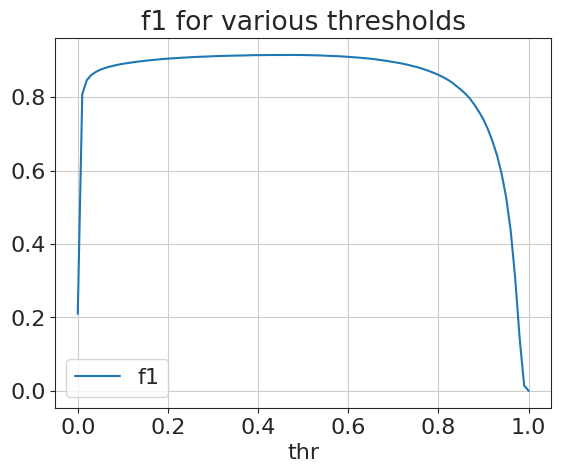

In [ ]:
# find the best thr
valid_all_emb['y_score'] = catboost.predict_proba(valid_all_emb[X])[:,1]# find the best threshold
res = []

for thr in tqdm(np.linspace(0,1,101)):
    res.append((thr,f1_score(valid_all_emb[y].astype('int'), valid_all_emb['y_score'] > thr)))
    df_f1 = pd.DataFrame(res,columns = ['thr','f1'])


# Visualize the result
df_f1.set_index('thr').plot()
plt.title('f1 for various thresholds')
plt.show()

In [ ]:
df_f1.sort_values('f1',ascending = False)

,thr,f1
48,0.48,0.915006
47,0.47,0.914861
45,0.45,0.914844
49,0.49,0.914826
43,0.43,0.914822
...,...,...
97,0.97,0.308422
0,0.00,0.209728
98,0.98,0.143081
99,0.99,0.014699


In [ ]:
best_thr_idx = df_f1.sort_values('f1', ascending = False)['thr'].head(1).index
thr = float(df_f1.iloc[best_thr_idx]['thr'])
thr

/tmp/ipykernel_2350/185519335.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  thr = float(df_f1.iloc[best_thr_idx]['thr'])


0.48

In [ ]:
# train on the whole data
catboost = CatBoostClassifier(**best_params)
# Loop over batches
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size if (i + 1) * batch_size < len(train_idx) else len(train_idx)

    # Create a batch Pool
    batch_pool = Pool(data = train_all.iloc[start_idx : end_idx][X],
                      label = train_all.iloc[start_idx : end_idx][y])

    catboost.fit(batch_pool, eval_set = None)
    gc.collect()

  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.8990053	total: 40.7ms	remaining: 40.7s
100:	learn: 0.9098033	total: 2.48s	remaining: 22s
200:	learn: 0.9168013	total: 4.83s	remaining: 19.2s
300:	learn: 0.9214188	total: 7.16s	remaining: 16.6s
400:	learn: 0.9274100	total: 9.52s	remaining: 14.2s
500:	learn: 0.9319816	total: 11.9s	remaining: 11.8s
600:	learn: 0.9362005	total: 14.2s	remaining: 9.41s
700:	learn: 0.9399230	total: 16.4s	remaining: 7.01s
800:	learn: 0.9440074	total: 18.7s	remaining: 4.65s
900:	learn: 0.9478076	total: 21s	remaining: 2.31s
999:	learn: 0.9503372	total: 23.4s	remaining: 0us
0:	learn: 0.9228177	total: 43.5ms	remaining: 43.4s
100:	learn: 0.9320767	total: 2.5s	remaining: 22.3s
200:	learn: 0.9363177	total: 4.85s	remaining: 19.3s
300:	learn: 0.9394672	total: 7.19s	remaining: 16.7s
400:	learn: 0.9419223	total: 9.52s	remaining: 14.2s
500:	learn: 0.9441908	total: 11.8s	remaining: 11.8s
600:	learn: 0.9463758	total: 14.2s	remaining: 9.41s
700:	learn: 0.9487077	total: 16.5s	remaining: 7.03s
800:	learn: 0.9503113

## Submission

In [ ]:
# make preds on test
prediction = catboost.predict_proba(test[X])

In [ ]:
y_test = (prediction > thr).astype('int')[:,1]
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
submit_example = pd.read_csv('/kaggle/input/samokat-tech/sample_submission.csv')
submit_example.columns

Index(['id', 'target'], dtype='object')

In [ ]:
submit = submit_example
submit['target'] = y_test
submit.to_csv('submit_last.csv', index=False)

In [ ]:
submit_example.index

# Conclusions

As a result of my research, I explored two gradient boosting algorithm models:
- CatBoost model
- LightGBM.

As a baseline result, I obtained results on data without embeddings of product descriptions and images. Both models yielded comparable results.
I did not balance the target variable, despite the existing 11% class imbalance of positive labels. I didn't know what the balance would be in the test data, and as a measure to handle imbalance, I examined different thresholds.

|Model    |Metric   | thr |
|---------|---------|-----|
|LightGBM |0.844486 | 0.40|
|CatBoost | 0.848323| 0.44 |

CatBoost produced better results, prompting me to optimize its hyperparameters using Optuna. The parameter grid specifically targeted two hyperparameters: learning rate and leaf regularization. My hypothesis was to counteract the influence of the high learning rate by regularization.

After tunint the metric was:
- 0.868007 with thr 0.44.

Subsequently, I sequentially added embeddings and compared the outcomes.  F1 metric value was  significantly improved on data with all embeddings altogether.

Interestingly, one of the features became more important than the combined feature of 'attrs + title score,' which was the most crucial for the models. This raised concerns for me regarding the adequacy of a model that relies on a single feature for prediction, specifically the outcome of another model. I tried also to predict without that feature (metric was 0.86 on data with all embeddings).

Before incorporating embeddings, I computed a vector representing the Euclidean distance between the image and title embeddings. It seems to me that using cosine distance calculations might be more appropriate. I did not conduct feature scaling due to the substantial data volume, making it challenging to process so i could not to use this cosine distance.

The best f1 score I ve obtained is
0.91781.




<div class="alert alert-block alert-success">

Отлично, итоговый вывод сформулирован)

Молодец, что объеденила результаты обучения модели в таблицу. МОжно ещё добавить время обучения и предсказания модели, так как в некоторых случаях это может быть важная характеристика модели.
    
Да, отличная идея попробовать добавить регуляризацию. 👍👍👍
    
</div>